In [1]:
import keras

import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Activation, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.preprocessing import OneHotEncoder

import numpy as np


TRAIN_DATA_PATH = '../data/test_train_split/training_split_deid_April_27_2022.csv'
TEST_DATA_PATH = '../data/test_train_split/test_split_deid_April_27_2022.csv'
TARGET_NAME = 'LT4'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


2022-05-01 19:58:44.779943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 19:58:44.780204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 19:58:44.784765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 19:58:44.785024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 19:58:44.785247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [3]:
# x_train = features, y_train = target
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

In [4]:
# function that does one hot encoding on categorical variables
def one_hot_encoder(x):
    ohe = OneHotEncoder()
    dat = x.to_numpy().reshape(len(x), 1)
    result = ohe.fit_transform(dat)
    return result.toarray()

In [5]:
tmp = one_hot_encoder(train_data['Gender'])
tmp = pd.DataFrame(tmp, columns=list(['Female', 'Male']))
train_data = pd.concat([train_data, tmp], axis=1)

tmp = one_hot_encoder(test_data['Gender'])
tmp = pd.DataFrame(tmp, columns=list(['Female', 'Male']))
test_data = pd.concat([test_data, tmp], axis=1)


In [6]:
tmp = one_hot_encoder(train_data['Calcium'])
tmp = pd.DataFrame(tmp, columns=list(['No_calcium', 'Takes_calcium']))
train_data = pd.concat([train_data, tmp], axis=1)

tmp = one_hot_encoder(test_data['Calcium'])
tmp = pd.DataFrame(tmp, columns=list(['No_calcium', 'Takes_calcium']))
test_data = pd.concat([test_data, tmp], axis=1)


In [7]:
# this calculates accuracy of predicting exact rounded dose
LT_doses = [75, 88 ,100, 112, 125, 137, 150, 175, 200, 224, 250]

# function rounds to a nearest dose in a list
def closest_value(input_list, input_value): 
    arr = np.asarray(input_list)
    i = (np.abs(arr - input_value)).argmin()
    return arr[i]

In [8]:
# rounding LT4 to prescribable doses 
rounded_LT4 = train_data['LT4'].to_list()
train_data['LT4_rounded'] = [closest_value(LT_doses, x) for x in rounded_LT4]

rounded_LT4 = test_data['LT4'].to_list()
test_data['LT4_rounded'] = [closest_value(LT_doses, x) for x in rounded_LT4]

In [9]:
tmp = one_hot_encoder(train_data['LT4_rounded'])
tmp = pd.DataFrame(tmp, columns=LT_doses)
train_data = pd.concat([train_data, tmp], axis=1)

tmp = one_hot_encoder(test_data['LT4_rounded'])
tmp = pd.DataFrame(tmp, columns=LT_doses)
test_data = pd.concat([test_data, tmp], axis=1)


In [10]:
variables = ['logTSH', 'Weight', 'Height', 'Female', 'Male', 'Age', 'Takes_calcium', 'No_calcium']
variables = variables + LT_doses
print(variables)

['logTSH', 'Weight', 'Height', 'Female', 'Male', 'Age', 'Takes_calcium', 'No_calcium', 75, 88, 100, 112, 125, 137, 150, 175, 200, 224, 250]


In [11]:
train = train_data[variables]
test = test_data[variables]

In [12]:
x_train, y_train = train.drop(LT_doses, axis=1), train[LT_doses]
x_test, y_test = test.drop(LT_doses, axis=1), test[LT_doses]

In [13]:
"""
  Standard Scale test and train data
  Z - Score normalization
"""
def scale_datasets(x_train, x_test):
    standard_scaler = StandardScaler()
  
    x_train_scaled = pd.DataFrame(
        standard_scaler.fit_transform(x_train),
        columns=x_train.columns
    )

    x_test_scaled = pd.DataFrame(
        standard_scaler.transform(x_test),
        columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled

x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

In [14]:
x_train_scaled = np.array(x_train_scaled)
x_test_scaled = np.array(x_test_scaled)

In [15]:
# defining fully connected NN model

hidden_units1 = 64
hidden_units2 = 256
hidden_units3 = 32

learning_rate = 0.0005

# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.49),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.69),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dropout(0.33),
    Dense(11, kernel_initializer='normal', activation='softmax')
  ])
  return model



In [17]:
accuracy_exact = []
accuracy_exact_normal = []

for i in range(10):
    
    # build the model
    model = build_model_using_sequential()
    
    # loss function
    ccle = CategoricalCrossentropy()
    
    model.compile(
        loss=ccle, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[ccle]
    )
    # train the model
    history = model.fit(
        x_train_scaled, 
        y_train, 
        epochs=500,
        batch_size=128,
        validation_split=0.2
    )
    
    # evaluating on test data and calculating accuracy
    
    class_labels = np.argmax(model.predict(x_test_scaled), axis=1)
    x_test['prediction'] = np.array(LT_doses)[class_labels.astype(int)]
    x_test['LT4'] = np.array(LT_doses)[np.where(y_test==1)[1].astype('int')]
    
    print("Run " + str(i+1) + " exact LT4 dose: ", sum(x_test['LT4'] == x_test['prediction'])/x_test.shape[0])
    accuracy_exact.append(sum(x_test['LT4'] == x_test['prediction'])/x_test.shape[0])
    
    x_test['TSH'] = np.exp(x_test['logTSH'])
    x_test_normal = x_test[x_test['TSH'] > 0.45]
    x_test_normal = x_test_normal[x_test_normal['TSH'] < 4.5]
    print("Run " + str(i+1) + " exact LT4 dose normal TSH: ", sum(x_test_normal['LT4'] == x_test_normal['prediction'])/x_test_normal.shape[0])
    accuracy_exact_normal.append(sum(x_test_normal['LT4'] == x_test_normal['prediction'])/x_test_normal.shape[0])
    
    
    
    

Epoch 1/500
5/5 [==============================] - 0s 31ms/step - loss: 2.3950 - categorical_crossentropy: 2.3950 - val_loss: 2.3934 - val_categorical_crossentropy: 2.3936
Epoch 2/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3913 - categorical_crossentropy: 2.3911 - val_loss: 2.3889 - val_categorical_crossentropy: 2.3889
Epoch 3/500
5/5 [==============================] - 0s 8ms/step - loss: 2.3838 - categorical_crossentropy: 2.3835 - val_loss: 2.3834 - val_categorical_crossentropy: 2.3833
Epoch 4/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3771 - categorical_crossentropy: 2.3770 - val_loss: 2.3762 - val_categorical_crossentropy: 2.3760
Epoch 5/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3684 - categorical_crossentropy: 2.3680 - val_loss: 2.3669 - val_categorical_crossentropy: 2.3664
Epoch 6/500
5/5 [==============================] - 0s 8ms/step - loss: 2.3573 - categorical_crossentropy: 2.3568 - val_loss: 2.3546 - val_catego

Epoch 49/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5847 - categorical_crossentropy: 1.5911 - val_loss: 1.4792 - val_categorical_crossentropy: 1.4680
Epoch 50/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5976 - categorical_crossentropy: 1.5984 - val_loss: 1.4659 - val_categorical_crossentropy: 1.4596
Epoch 51/500
5/5 [==============================] - 0s 8ms/step - loss: 1.5803 - categorical_crossentropy: 1.5821 - val_loss: 1.4576 - val_categorical_crossentropy: 1.4536
Epoch 52/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5767 - categorical_crossentropy: 1.5817 - val_loss: 1.4562 - val_categorical_crossentropy: 1.4522
Epoch 53/500
5/5 [==============================] - 0s 8ms/step - loss: 1.5791 - categorical_crossentropy: 1.5807 - val_loss: 1.4557 - val_categorical_crossentropy: 1.4529
Epoch 54/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5642 - categorical_crossentropy: 1.5664 - val_loss: 1.4500 - val_c

5/5 [==============================] - 0s 9ms/step - loss: 1.4896 - categorical_crossentropy: 1.4928 - val_loss: 1.3502 - val_categorical_crossentropy: 1.3835
Epoch 97/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4772 - categorical_crossentropy: 1.4812 - val_loss: 1.3533 - val_categorical_crossentropy: 1.3867
Epoch 98/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4587 - categorical_crossentropy: 1.4593 - val_loss: 1.3616 - val_categorical_crossentropy: 1.3940
Epoch 99/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4627 - categorical_crossentropy: 1.4563 - val_loss: 1.3660 - val_categorical_crossentropy: 1.3958
Epoch 100/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4274 - categorical_crossentropy: 1.4298 - val_loss: 1.3586 - val_categorical_crossentropy: 1.3913
Epoch 101/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4648 - categorical_crossentropy: 1.4625 - val_loss: 1.3505 - val_categorical_

5/5 [==============================] - 0s 9ms/step - loss: 1.4327 - categorical_crossentropy: 1.4299 - val_loss: 1.3178 - val_categorical_crossentropy: 1.3645
Epoch 144/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4305 - categorical_crossentropy: 1.4273 - val_loss: 1.3175 - val_categorical_crossentropy: 1.3661
Epoch 145/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4468 - categorical_crossentropy: 1.4468 - val_loss: 1.3214 - val_categorical_crossentropy: 1.3694
Epoch 146/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4050 - categorical_crossentropy: 1.4067 - val_loss: 1.3261 - val_categorical_crossentropy: 1.3713
Epoch 147/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3984 - categorical_crossentropy: 1.4011 - val_loss: 1.3241 - val_categorical_crossentropy: 1.3692
Epoch 148/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4093 - categorical_crossentropy: 1.4081 - val_loss: 1.3151 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3805 - categorical_crossentropy: 1.3830 - val_loss: 1.3014 - val_categorical_crossentropy: 1.3605
Epoch 191/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3605 - categorical_crossentropy: 1.3584 - val_loss: 1.3007 - val_categorical_crossentropy: 1.3596
Epoch 192/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3922 - categorical_crossentropy: 1.3915 - val_loss: 1.3012 - val_categorical_crossentropy: 1.3575
Epoch 193/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3877 - categorical_crossentropy: 1.3805 - val_loss: 1.3040 - val_categorical_crossentropy: 1.3594
Epoch 194/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4085 - categorical_crossentropy: 1.4100 - val_loss: 1.3044 - val_categorical_crossentropy: 1.3597
Epoch 195/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3986 - categorical_crossentropy: 1.4048 - val_loss: 1.3002 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3634 - categorical_crossentropy: 1.3658 - val_loss: 1.2898 - val_categorical_crossentropy: 1.3526
Epoch 238/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3323 - categorical_crossentropy: 1.3326 - val_loss: 1.2909 - val_categorical_crossentropy: 1.3547
Epoch 239/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3609 - categorical_crossentropy: 1.3583 - val_loss: 1.2899 - val_categorical_crossentropy: 1.3545
Epoch 240/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3632 - categorical_crossentropy: 1.3644 - val_loss: 1.2872 - val_categorical_crossentropy: 1.3570
Epoch 241/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3521 - categorical_crossentropy: 1.3542 - val_loss: 1.2906 - val_categorical_crossentropy: 1.3618
Epoch 242/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3726 - categorical_crossentropy: 1.3699 - val_loss: 1.2997 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3474 - categorical_crossentropy: 1.3472 - val_loss: 1.2909 - val_categorical_crossentropy: 1.3613
Epoch 285/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3796 - categorical_crossentropy: 1.3806 - val_loss: 1.2883 - val_categorical_crossentropy: 1.3574
Epoch 286/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3422 - categorical_crossentropy: 1.3423 - val_loss: 1.2864 - val_categorical_crossentropy: 1.3562
Epoch 287/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3516 - categorical_crossentropy: 1.3497 - val_loss: 1.2874 - val_categorical_crossentropy: 1.3571
Epoch 288/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3601 - categorical_crossentropy: 1.3586 - val_loss: 1.2949 - val_categorical_crossentropy: 1.3654
Epoch 289/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3311 - categorical_crossentropy: 1.3305 - val_loss: 1.3005 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3552 - categorical_crossentropy: 1.3581 - val_loss: 1.2854 - val_categorical_crossentropy: 1.3688
Epoch 332/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3257 - categorical_crossentropy: 1.3213 - val_loss: 1.2887 - val_categorical_crossentropy: 1.3722
Epoch 333/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3485 - categorical_crossentropy: 1.3467 - val_loss: 1.2881 - val_categorical_crossentropy: 1.3726
Epoch 334/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3507 - categorical_crossentropy: 1.3537 - val_loss: 1.2917 - val_categorical_crossentropy: 1.3719
Epoch 335/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3293 - categorical_crossentropy: 1.3268 - val_loss: 1.2952 - val_categorical_crossentropy: 1.3757
Epoch 336/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3210 - categorical_crossentropy: 1.3252 - val_loss: 1.2928 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3012 - categorical_crossentropy: 1.3046 - val_loss: 1.2930 - val_categorical_crossentropy: 1.3793
Epoch 379/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3325 - categorical_crossentropy: 1.3336 - val_loss: 1.2864 - val_categorical_crossentropy: 1.3735
Epoch 380/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2809 - categorical_crossentropy: 1.2822 - val_loss: 1.2814 - val_categorical_crossentropy: 1.3706
Epoch 381/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2975 - categorical_crossentropy: 1.2972 - val_loss: 1.2771 - val_categorical_crossentropy: 1.3702
Epoch 382/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3442 - categorical_crossentropy: 1.3441 - val_loss: 1.2812 - val_categorical_crossentropy: 1.3722
Epoch 383/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3528 - categorical_crossentropy: 1.3548 - val_loss: 1.2842 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3059 - categorical_crossentropy: 1.3088 - val_loss: 1.2870 - val_categorical_crossentropy: 1.3768
Epoch 426/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3137 - categorical_crossentropy: 1.3162 - val_loss: 1.2925 - val_categorical_crossentropy: 1.3834
Epoch 427/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3048 - categorical_crossentropy: 1.3047 - val_loss: 1.2941 - val_categorical_crossentropy: 1.3841
Epoch 428/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3117 - categorical_crossentropy: 1.3131 - val_loss: 1.2879 - val_categorical_crossentropy: 1.3788
Epoch 429/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3293 - categorical_crossentropy: 1.3280 - val_loss: 1.2833 - val_categorical_crossentropy: 1.3774
Epoch 430/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3195 - categorical_crossentropy: 1.3227 - val_loss: 1.2845 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3273 - categorical_crossentropy: 1.3232 - val_loss: 1.2827 - val_categorical_crossentropy: 1.3765
Epoch 473/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2669 - categorical_crossentropy: 1.2724 - val_loss: 1.2802 - val_categorical_crossentropy: 1.3742
Epoch 474/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2912 - categorical_crossentropy: 1.2929 - val_loss: 1.2835 - val_categorical_crossentropy: 1.3747
Epoch 475/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2802 - categorical_crossentropy: 1.2843 - val_loss: 1.2902 - val_categorical_crossentropy: 1.3785
Epoch 476/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2970 - categorical_crossentropy: 1.2961 - val_loss: 1.2929 - val_categorical_crossentropy: 1.3813
Epoch 477/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3171 - categorical_crossentropy: 1.3179 - val_loss: 1.2885 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 2.0608 - categorical_crossentropy: 2.0649 - val_loss: 2.0129 - val_categorical_crossentropy: 1.9700
Epoch 20/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0461 - categorical_crossentropy: 2.0475 - val_loss: 1.9848 - val_categorical_crossentropy: 1.9401
Epoch 21/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0017 - categorical_crossentropy: 2.0066 - val_loss: 1.9555 - val_categorical_crossentropy: 1.9094
Epoch 22/500
5/5 [==============================] - 0s 9ms/step - loss: 1.9697 - categorical_crossentropy: 1.9685 - val_loss: 1.9272 - val_categorical_crossentropy: 1.8796
Epoch 23/500
5/5 [==============================] - 0s 9ms/step - loss: 1.9555 - categorical_crossentropy: 1.9573 - val_loss: 1.9016 - val_categorical_crossentropy: 1.8521
Epoch 24/500
5/5 [==============================] - 0s 9ms/step - loss: 1.9463 - categorical_crossentropy: 1.9467 - val_loss: 1.8767 - val_categorical_cr

Epoch 67/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5570 - categorical_crossentropy: 1.5562 - val_loss: 1.4295 - val_categorical_crossentropy: 1.4404
Epoch 68/500
5/5 [==============================] - 0s 8ms/step - loss: 1.5221 - categorical_crossentropy: 1.5226 - val_loss: 1.4212 - val_categorical_crossentropy: 1.4326
Epoch 69/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5552 - categorical_crossentropy: 1.5504 - val_loss: 1.4187 - val_categorical_crossentropy: 1.4285
Epoch 70/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5438 - categorical_crossentropy: 1.5450 - val_loss: 1.4182 - val_categorical_crossentropy: 1.4278
Epoch 71/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5415 - categorical_crossentropy: 1.5414 - val_loss: 1.4209 - val_categorical_crossentropy: 1.4313
Epoch 72/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5228 - categorical_crossentropy: 1.5224 - val_loss: 1.4124 - val_c

5/5 [==============================] - 0s 8ms/step - loss: 1.4601 - categorical_crossentropy: 1.4633 - val_loss: 1.3482 - val_categorical_crossentropy: 1.3859
Epoch 115/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4492 - categorical_crossentropy: 1.4492 - val_loss: 1.3524 - val_categorical_crossentropy: 1.3907
Epoch 116/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4546 - categorical_crossentropy: 1.4569 - val_loss: 1.3482 - val_categorical_crossentropy: 1.3872
Epoch 117/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4470 - categorical_crossentropy: 1.4399 - val_loss: 1.3333 - val_categorical_crossentropy: 1.3765
Epoch 118/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4489 - categorical_crossentropy: 1.4441 - val_loss: 1.3272 - val_categorical_crossentropy: 1.3733
Epoch 119/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4845 - categorical_crossentropy: 1.4857 - val_loss: 1.3236 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.4017 - categorical_crossentropy: 1.3995 - val_loss: 1.3270 - val_categorical_crossentropy: 1.3791
Epoch 162/500
5/5 [==============================] - 0s 10ms/step - loss: 1.4056 - categorical_crossentropy: 1.4030 - val_loss: 1.3109 - val_categorical_crossentropy: 1.3671
Epoch 163/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4313 - categorical_crossentropy: 1.4353 - val_loss: 1.3040 - val_categorical_crossentropy: 1.3609
Epoch 164/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3826 - categorical_crossentropy: 1.3791 - val_loss: 1.3044 - val_categorical_crossentropy: 1.3615
Epoch 165/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3638 - categorical_crossentropy: 1.3649 - val_loss: 1.3090 - val_categorical_crossentropy: 1.3666
Epoch 166/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3885 - categorical_crossentropy: 1.3840 - val_loss: 1.3133 - val_categori

5/5 [==============================] - 0s 9ms/step - loss: 1.3798 - categorical_crossentropy: 1.3825 - val_loss: 1.3118 - val_categorical_crossentropy: 1.3763
Epoch 209/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3635 - categorical_crossentropy: 1.3621 - val_loss: 1.3120 - val_categorical_crossentropy: 1.3783
Epoch 210/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3807 - categorical_crossentropy: 1.3804 - val_loss: 1.3101 - val_categorical_crossentropy: 1.3775
Epoch 211/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3458 - categorical_crossentropy: 1.3417 - val_loss: 1.3020 - val_categorical_crossentropy: 1.3699
Epoch 212/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3826 - categorical_crossentropy: 1.3856 - val_loss: 1.2920 - val_categorical_crossentropy: 1.3619
Epoch 213/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3694 - categorical_crossentropy: 1.3714 - val_loss: 1.2905 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3666 - categorical_crossentropy: 1.3625 - val_loss: 1.2803 - val_categorical_crossentropy: 1.3583
Epoch 256/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3919 - categorical_crossentropy: 1.3876 - val_loss: 1.2795 - val_categorical_crossentropy: 1.3593
Epoch 257/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3515 - categorical_crossentropy: 1.3494 - val_loss: 1.2826 - val_categorical_crossentropy: 1.3610
Epoch 258/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3544 - categorical_crossentropy: 1.3533 - val_loss: 1.2901 - val_categorical_crossentropy: 1.3680
Epoch 259/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3437 - categorical_crossentropy: 1.3448 - val_loss: 1.2934 - val_categorical_crossentropy: 1.3698
Epoch 260/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3427 - categorical_crossentropy: 1.3417 - val_loss: 1.2923 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3396 - categorical_crossentropy: 1.3368 - val_loss: 1.2778 - val_categorical_crossentropy: 1.3638
Epoch 303/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3293 - categorical_crossentropy: 1.3324 - val_loss: 1.2746 - val_categorical_crossentropy: 1.3616
Epoch 304/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3686 - categorical_crossentropy: 1.3638 - val_loss: 1.2729 - val_categorical_crossentropy: 1.3600
Epoch 305/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3253 - categorical_crossentropy: 1.3226 - val_loss: 1.2829 - val_categorical_crossentropy: 1.3674
Epoch 306/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3497 - categorical_crossentropy: 1.3499 - val_loss: 1.2876 - val_categorical_crossentropy: 1.3697
Epoch 307/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3249 - categorical_crossentropy: 1.3259 - val_loss: 1.2851 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3228 - categorical_crossentropy: 1.3225 - val_loss: 1.2784 - val_categorical_crossentropy: 1.3600
Epoch 350/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3066 - categorical_crossentropy: 1.3081 - val_loss: 1.2745 - val_categorical_crossentropy: 1.3568
Epoch 351/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3155 - categorical_crossentropy: 1.3169 - val_loss: 1.2734 - val_categorical_crossentropy: 1.3542
Epoch 352/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3215 - categorical_crossentropy: 1.3163 - val_loss: 1.2795 - val_categorical_crossentropy: 1.3591
Epoch 353/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3157 - categorical_crossentropy: 1.3132 - val_loss: 1.2896 - val_categorical_crossentropy: 1.3663
Epoch 354/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3331 - categorical_crossentropy: 1.3367 - val_loss: 1.2939 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3158 - categorical_crossentropy: 1.3113 - val_loss: 1.2871 - val_categorical_crossentropy: 1.3670
Epoch 397/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3102 - categorical_crossentropy: 1.3171 - val_loss: 1.2855 - val_categorical_crossentropy: 1.3639
Epoch 398/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2963 - categorical_crossentropy: 1.2934 - val_loss: 1.2775 - val_categorical_crossentropy: 1.3624
Epoch 399/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3089 - categorical_crossentropy: 1.3047 - val_loss: 1.2719 - val_categorical_crossentropy: 1.3629
Epoch 400/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3327 - categorical_crossentropy: 1.3344 - val_loss: 1.2706 - val_categorical_crossentropy: 1.3647
Epoch 401/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2808 - categorical_crossentropy: 1.2828 - val_loss: 1.2730 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.2926 - categorical_crossentropy: 1.2966 - val_loss: 1.2783 - val_categorical_crossentropy: 1.3655
Epoch 444/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2882 - categorical_crossentropy: 1.2880 - val_loss: 1.2780 - val_categorical_crossentropy: 1.3645
Epoch 445/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2708 - categorical_crossentropy: 1.2709 - val_loss: 1.2766 - val_categorical_crossentropy: 1.3637
Epoch 446/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3092 - categorical_crossentropy: 1.3072 - val_loss: 1.2746 - val_categorical_crossentropy: 1.3628
Epoch 447/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2850 - categorical_crossentropy: 1.2835 - val_loss: 1.2753 - val_categorical_crossentropy: 1.3636
Epoch 448/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2768 - categorical_crossentropy: 1.2798 - val_loss: 1.2760 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.2912 - categorical_crossentropy: 1.2887 - val_loss: 1.2887 - val_categorical_crossentropy: 1.3755
Epoch 491/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2838 - categorical_crossentropy: 1.2882 - val_loss: 1.2841 - val_categorical_crossentropy: 1.3740
Epoch 492/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2924 - categorical_crossentropy: 1.2896 - val_loss: 1.2786 - val_categorical_crossentropy: 1.3724
Epoch 493/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2734 - categorical_crossentropy: 1.2784 - val_loss: 1.2782 - val_categorical_crossentropy: 1.3735
Epoch 494/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2761 - categorical_crossentropy: 1.2787 - val_loss: 1.2766 - val_categorical_crossentropy: 1.3720
Epoch 495/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2871 - categorical_crossentropy: 1.2899 - val_loss: 1.2746 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.7127 - categorical_crossentropy: 1.7160 - val_loss: 1.6160 - val_categorical_crossentropy: 1.5753
Epoch 38/500
5/5 [==============================] - 0s 8ms/step - loss: 1.7232 - categorical_crossentropy: 1.7265 - val_loss: 1.6026 - val_categorical_crossentropy: 1.5645
Epoch 39/500
5/5 [==============================] - 0s 9ms/step - loss: 1.7127 - categorical_crossentropy: 1.7121 - val_loss: 1.5893 - val_categorical_crossentropy: 1.5536
Epoch 40/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6870 - categorical_crossentropy: 1.6846 - val_loss: 1.5787 - val_categorical_crossentropy: 1.5456
Epoch 41/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6792 - categorical_crossentropy: 1.6834 - val_loss: 1.5691 - val_categorical_crossentropy: 1.5355
Epoch 42/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6887 - categorical_crossentropy: 1.6873 - val_loss: 1.5593 - val_categorical_cr

Epoch 85/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5175 - categorical_crossentropy: 1.5175 - val_loss: 1.3785 - val_categorical_crossentropy: 1.4060
Epoch 86/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4825 - categorical_crossentropy: 1.4870 - val_loss: 1.3738 - val_categorical_crossentropy: 1.4037
Epoch 87/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5097 - categorical_crossentropy: 1.5097 - val_loss: 1.3689 - val_categorical_crossentropy: 1.4007
Epoch 88/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4813 - categorical_crossentropy: 1.4769 - val_loss: 1.3683 - val_categorical_crossentropy: 1.3993
Epoch 89/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5035 - categorical_crossentropy: 1.4992 - val_loss: 1.3681 - val_categorical_crossentropy: 1.3968
Epoch 90/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5032 - categorical_crossentropy: 1.5074 - val_loss: 1.3775 - val_c

5/5 [==============================] - 0s 8ms/step - loss: 1.4168 - categorical_crossentropy: 1.4158 - val_loss: 1.3101 - val_categorical_crossentropy: 1.3599
Epoch 133/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4165 - categorical_crossentropy: 1.4130 - val_loss: 1.3140 - val_categorical_crossentropy: 1.3626
Epoch 134/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4466 - categorical_crossentropy: 1.4464 - val_loss: 1.3112 - val_categorical_crossentropy: 1.3600
Epoch 135/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4427 - categorical_crossentropy: 1.4415 - val_loss: 1.3073 - val_categorical_crossentropy: 1.3578
Epoch 136/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4392 - categorical_crossentropy: 1.4372 - val_loss: 1.3129 - val_categorical_crossentropy: 1.3633
Epoch 137/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4472 - categorical_crossentropy: 1.4427 - val_loss: 1.3221 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3912 - categorical_crossentropy: 1.3904 - val_loss: 1.2953 - val_categorical_crossentropy: 1.3499
Epoch 180/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4311 - categorical_crossentropy: 1.4321 - val_loss: 1.3010 - val_categorical_crossentropy: 1.3526
Epoch 181/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3852 - categorical_crossentropy: 1.3864 - val_loss: 1.3095 - val_categorical_crossentropy: 1.3586
Epoch 182/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3777 - categorical_crossentropy: 1.3760 - val_loss: 1.3108 - val_categorical_crossentropy: 1.3594
Epoch 183/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3816 - categorical_crossentropy: 1.3812 - val_loss: 1.3065 - val_categorical_crossentropy: 1.3590
Epoch 184/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3740 - categorical_crossentropy: 1.3806 - val_loss: 1.3024 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3716 - categorical_crossentropy: 1.3661 - val_loss: 1.2866 - val_categorical_crossentropy: 1.3507
Epoch 227/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3407 - categorical_crossentropy: 1.3403 - val_loss: 1.2905 - val_categorical_crossentropy: 1.3565
Epoch 228/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3617 - categorical_crossentropy: 1.3617 - val_loss: 1.2956 - val_categorical_crossentropy: 1.3634
Epoch 229/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3569 - categorical_crossentropy: 1.3619 - val_loss: 1.2949 - val_categorical_crossentropy: 1.3595
Epoch 230/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3695 - categorical_crossentropy: 1.3686 - val_loss: 1.2956 - val_categorical_crossentropy: 1.3611
Epoch 231/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3579 - categorical_crossentropy: 1.3563 - val_loss: 1.2899 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3686 - categorical_crossentropy: 1.3705 - val_loss: 1.2872 - val_categorical_crossentropy: 1.3548
Epoch 274/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3196 - categorical_crossentropy: 1.3176 - val_loss: 1.2889 - val_categorical_crossentropy: 1.3593
Epoch 275/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3449 - categorical_crossentropy: 1.3401 - val_loss: 1.2878 - val_categorical_crossentropy: 1.3582
Epoch 276/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3503 - categorical_crossentropy: 1.3505 - val_loss: 1.2852 - val_categorical_crossentropy: 1.3544
Epoch 277/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3785 - categorical_crossentropy: 1.3791 - val_loss: 1.2884 - val_categorical_crossentropy: 1.3570
Epoch 278/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3479 - categorical_crossentropy: 1.3492 - val_loss: 1.2889 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3232 - categorical_crossentropy: 1.3213 - val_loss: 1.2793 - val_categorical_crossentropy: 1.3537
Epoch 321/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2940 - categorical_crossentropy: 1.2906 - val_loss: 1.2798 - val_categorical_crossentropy: 1.3555
Epoch 322/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3273 - categorical_crossentropy: 1.3233 - val_loss: 1.2784 - val_categorical_crossentropy: 1.3547
Epoch 323/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3436 - categorical_crossentropy: 1.3461 - val_loss: 1.2777 - val_categorical_crossentropy: 1.3547
Epoch 324/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3312 - categorical_crossentropy: 1.3337 - val_loss: 1.2798 - val_categorical_crossentropy: 1.3564
Epoch 325/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3406 - categorical_crossentropy: 1.3421 - val_loss: 1.2886 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3264 - categorical_crossentropy: 1.3266 - val_loss: 1.2778 - val_categorical_crossentropy: 1.3552
Epoch 368/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3063 - categorical_crossentropy: 1.3089 - val_loss: 1.2748 - val_categorical_crossentropy: 1.3529
Epoch 369/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3355 - categorical_crossentropy: 1.3347 - val_loss: 1.2802 - val_categorical_crossentropy: 1.3577
Epoch 370/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3252 - categorical_crossentropy: 1.3307 - val_loss: 1.2841 - val_categorical_crossentropy: 1.3617
Epoch 371/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3014 - categorical_crossentropy: 1.3007 - val_loss: 1.2885 - val_categorical_crossentropy: 1.3653
Epoch 372/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3083 - categorical_crossentropy: 1.3125 - val_loss: 1.2870 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3302 - categorical_crossentropy: 1.3306 - val_loss: 1.2890 - val_categorical_crossentropy: 1.3689
Epoch 415/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2975 - categorical_crossentropy: 1.2965 - val_loss: 1.2851 - val_categorical_crossentropy: 1.3657
Epoch 416/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2573 - categorical_crossentropy: 1.2536 - val_loss: 1.2822 - val_categorical_crossentropy: 1.3626
Epoch 417/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3542 - categorical_crossentropy: 1.3571 - val_loss: 1.2811 - val_categorical_crossentropy: 1.3602
Epoch 418/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3027 - categorical_crossentropy: 1.3017 - val_loss: 1.2814 - val_categorical_crossentropy: 1.3617
Epoch 419/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3068 - categorical_crossentropy: 1.3121 - val_loss: 1.2814 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3154 - categorical_crossentropy: 1.3171 - val_loss: 1.2826 - val_categorical_crossentropy: 1.3615
Epoch 462/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2918 - categorical_crossentropy: 1.2917 - val_loss: 1.2825 - val_categorical_crossentropy: 1.3631
Epoch 463/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3282 - categorical_crossentropy: 1.3250 - val_loss: 1.2826 - val_categorical_crossentropy: 1.3660
Epoch 464/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2813 - categorical_crossentropy: 1.2865 - val_loss: 1.2799 - val_categorical_crossentropy: 1.3672
Epoch 465/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2875 - categorical_crossentropy: 1.2872 - val_loss: 1.2782 - val_categorical_crossentropy: 1.3657
Epoch 466/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2959 - categorical_crossentropy: 1.2960 - val_loss: 1.2871 - val_categoric

Epoch 8/500
5/5 [==============================] - 0s 8ms/step - loss: 2.3235 - categorical_crossentropy: 2.3240 - val_loss: 2.3184 - val_categorical_crossentropy: 2.3126
Epoch 9/500
5/5 [==============================] - 0s 9ms/step - loss: 2.2951 - categorical_crossentropy: 2.2948 - val_loss: 2.2889 - val_categorical_crossentropy: 2.2806
Epoch 10/500
5/5 [==============================] - 0s 9ms/step - loss: 2.2674 - categorical_crossentropy: 2.2659 - val_loss: 2.2529 - val_categorical_crossentropy: 2.2410
Epoch 11/500
5/5 [==============================] - 0s 9ms/step - loss: 2.2231 - categorical_crossentropy: 2.2220 - val_loss: 2.2121 - val_categorical_crossentropy: 2.1962
Epoch 12/500
5/5 [==============================] - 0s 9ms/step - loss: 2.1846 - categorical_crossentropy: 2.1850 - val_loss: 2.1709 - val_categorical_crossentropy: 2.1502
Epoch 13/500
5/5 [==============================] - 0s 9ms/step - loss: 2.1452 - categorical_crossentropy: 2.1432 - val_loss: 2.1373 - val_cat

Epoch 56/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5891 - categorical_crossentropy: 1.5914 - val_loss: 1.4632 - val_categorical_crossentropy: 1.4575
Epoch 57/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5867 - categorical_crossentropy: 1.5921 - val_loss: 1.4637 - val_categorical_crossentropy: 1.4561
Epoch 58/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5746 - categorical_crossentropy: 1.5746 - val_loss: 1.4587 - val_categorical_crossentropy: 1.4528
Epoch 59/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5911 - categorical_crossentropy: 1.5897 - val_loss: 1.4504 - val_categorical_crossentropy: 1.4482
Epoch 60/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5693 - categorical_crossentropy: 1.5700 - val_loss: 1.4409 - val_categorical_crossentropy: 1.4424
Epoch 61/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5508 - categorical_crossentropy: 1.5538 - val_loss: 1.4337 - val_c

5/5 [==============================] - 0s 9ms/step - loss: 1.4694 - categorical_crossentropy: 1.4680 - val_loss: 1.3669 - val_categorical_crossentropy: 1.3902
Epoch 104/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4562 - categorical_crossentropy: 1.4569 - val_loss: 1.3645 - val_categorical_crossentropy: 1.3882
Epoch 105/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4606 - categorical_crossentropy: 1.4628 - val_loss: 1.3558 - val_categorical_crossentropy: 1.3806
Epoch 106/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4735 - categorical_crossentropy: 1.4761 - val_loss: 1.3471 - val_categorical_crossentropy: 1.3743
Epoch 107/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4451 - categorical_crossentropy: 1.4461 - val_loss: 1.3448 - val_categorical_crossentropy: 1.3722
Epoch 108/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4312 - categorical_crossentropy: 1.4300 - val_loss: 1.3499 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.4273 - categorical_crossentropy: 1.4276 - val_loss: 1.3185 - val_categorical_crossentropy: 1.3577
Epoch 151/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4173 - categorical_crossentropy: 1.4219 - val_loss: 1.3161 - val_categorical_crossentropy: 1.3559
Epoch 152/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4278 - categorical_crossentropy: 1.4282 - val_loss: 1.3133 - val_categorical_crossentropy: 1.3523
Epoch 153/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4184 - categorical_crossentropy: 1.4206 - val_loss: 1.3127 - val_categorical_crossentropy: 1.3522
Epoch 154/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4142 - categorical_crossentropy: 1.4193 - val_loss: 1.3088 - val_categorical_crossentropy: 1.3497
Epoch 155/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3899 - categorical_crossentropy: 1.3909 - val_loss: 1.3064 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3697 - categorical_crossentropy: 1.3704 - val_loss: 1.2969 - val_categorical_crossentropy: 1.3581
Epoch 198/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4195 - categorical_crossentropy: 1.4204 - val_loss: 1.3004 - val_categorical_crossentropy: 1.3589
Epoch 199/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3753 - categorical_crossentropy: 1.3750 - val_loss: 1.2987 - val_categorical_crossentropy: 1.3546
Epoch 200/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3852 - categorical_crossentropy: 1.3870 - val_loss: 1.2957 - val_categorical_crossentropy: 1.3534
Epoch 201/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3909 - categorical_crossentropy: 1.3906 - val_loss: 1.2895 - val_categorical_crossentropy: 1.3489
Epoch 202/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4191 - categorical_crossentropy: 1.4141 - val_loss: 1.2898 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3579 - categorical_crossentropy: 1.3588 - val_loss: 1.2999 - val_categorical_crossentropy: 1.3559
Epoch 245/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3597 - categorical_crossentropy: 1.3581 - val_loss: 1.2966 - val_categorical_crossentropy: 1.3520
Epoch 246/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3359 - categorical_crossentropy: 1.3348 - val_loss: 1.2930 - val_categorical_crossentropy: 1.3503
Epoch 247/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3837 - categorical_crossentropy: 1.3853 - val_loss: 1.2943 - val_categorical_crossentropy: 1.3499
Epoch 248/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3528 - categorical_crossentropy: 1.3497 - val_loss: 1.2954 - val_categorical_crossentropy: 1.3539
Epoch 249/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3434 - categorical_crossentropy: 1.3472 - val_loss: 1.2954 - val_categoric

5/5 [==============================] - 0s 10ms/step - loss: 1.3452 - categorical_crossentropy: 1.3464 - val_loss: 1.2799 - val_categorical_crossentropy: 1.3451
Epoch 292/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3469 - categorical_crossentropy: 1.3492 - val_loss: 1.2826 - val_categorical_crossentropy: 1.3485
Epoch 293/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3233 - categorical_crossentropy: 1.3241 - val_loss: 1.2816 - val_categorical_crossentropy: 1.3483
Epoch 294/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3210 - categorical_crossentropy: 1.3204 - val_loss: 1.2797 - val_categorical_crossentropy: 1.3471
Epoch 295/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3409 - categorical_crossentropy: 1.3417 - val_loss: 1.2738 - val_categorical_crossentropy: 1.3416
Epoch 296/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3415 - categorical_crossentropy: 1.3403 - val_loss: 1.2767 - val_categori

5/5 [==============================] - 0s 8ms/step - loss: 1.3481 - categorical_crossentropy: 1.3504 - val_loss: 1.2822 - val_categorical_crossentropy: 1.3457
Epoch 339/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3354 - categorical_crossentropy: 1.3406 - val_loss: 1.2847 - val_categorical_crossentropy: 1.3518
Epoch 340/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3134 - categorical_crossentropy: 1.3137 - val_loss: 1.2775 - val_categorical_crossentropy: 1.3484
Epoch 341/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3209 - categorical_crossentropy: 1.3232 - val_loss: 1.2743 - val_categorical_crossentropy: 1.3477
Epoch 342/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3230 - categorical_crossentropy: 1.3235 - val_loss: 1.2709 - val_categorical_crossentropy: 1.3442
Epoch 343/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3258 - categorical_crossentropy: 1.3245 - val_loss: 1.2711 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3034 - categorical_crossentropy: 1.3033 - val_loss: 1.2694 - val_categorical_crossentropy: 1.3529
Epoch 386/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3098 - categorical_crossentropy: 1.3104 - val_loss: 1.2681 - val_categorical_crossentropy: 1.3534
Epoch 387/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3089 - categorical_crossentropy: 1.3114 - val_loss: 1.2727 - val_categorical_crossentropy: 1.3538
Epoch 388/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3165 - categorical_crossentropy: 1.3217 - val_loss: 1.2798 - val_categorical_crossentropy: 1.3564
Epoch 389/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3116 - categorical_crossentropy: 1.3092 - val_loss: 1.2815 - val_categorical_crossentropy: 1.3548
Epoch 390/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3131 - categorical_crossentropy: 1.3173 - val_loss: 1.2783 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.2742 - categorical_crossentropy: 1.2725 - val_loss: 1.2807 - val_categorical_crossentropy: 1.3650
Epoch 433/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2758 - categorical_crossentropy: 1.2756 - val_loss: 1.2869 - val_categorical_crossentropy: 1.3674
Epoch 434/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3236 - categorical_crossentropy: 1.3236 - val_loss: 1.2907 - val_categorical_crossentropy: 1.3705
Epoch 435/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2775 - categorical_crossentropy: 1.2739 - val_loss: 1.2886 - val_categorical_crossentropy: 1.3693
Epoch 436/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3143 - categorical_crossentropy: 1.3194 - val_loss: 1.2896 - val_categorical_crossentropy: 1.3722
Epoch 437/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3010 - categorical_crossentropy: 1.3010 - val_loss: 1.2811 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3155 - categorical_crossentropy: 1.3197 - val_loss: 1.2796 - val_categorical_crossentropy: 1.3664
Epoch 480/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3299 - categorical_crossentropy: 1.3288 - val_loss: 1.2819 - val_categorical_crossentropy: 1.3682
Epoch 481/500
5/5 [==============================] - 0s 10ms/step - loss: 1.2767 - categorical_crossentropy: 1.2797 - val_loss: 1.2801 - val_categorical_crossentropy: 1.3686
Epoch 482/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2623 - categorical_crossentropy: 1.2604 - val_loss: 1.2790 - val_categorical_crossentropy: 1.3695
Epoch 483/500
5/5 [==============================] - 0s 10ms/step - loss: 1.3053 - categorical_crossentropy: 1.3061 - val_loss: 1.2789 - val_categorical_crossentropy: 1.3715
Epoch 484/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2891 - categorical_crossentropy: 1.2887 - val_loss: 1.2794 - val_categor

5/5 [==============================] - 0s 9ms/step - loss: 2.0713 - categorical_crossentropy: 2.0733 - val_loss: 2.0312 - val_categorical_crossentropy: 1.9769
Epoch 27/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0449 - categorical_crossentropy: 2.0424 - val_loss: 2.0209 - val_categorical_crossentropy: 1.9643
Epoch 28/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0523 - categorical_crossentropy: 2.0539 - val_loss: 2.0091 - val_categorical_crossentropy: 1.9506
Epoch 29/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0172 - categorical_crossentropy: 2.0198 - val_loss: 1.9958 - val_categorical_crossentropy: 1.9357
Epoch 30/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0029 - categorical_crossentropy: 2.0040 - val_loss: 1.9805 - val_categorical_crossentropy: 1.9201
Epoch 31/500
5/5 [==============================] - 0s 9ms/step - loss: 1.9871 - categorical_crossentropy: 1.9894 - val_loss: 1.9645 - val_categorical_cr

Epoch 74/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5809 - categorical_crossentropy: 1.5833 - val_loss: 1.4630 - val_categorical_crossentropy: 1.4680
Epoch 75/500
5/5 [==============================] - 0s 8ms/step - loss: 1.5466 - categorical_crossentropy: 1.5504 - val_loss: 1.4609 - val_categorical_crossentropy: 1.4662
Epoch 76/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5657 - categorical_crossentropy: 1.5687 - val_loss: 1.4581 - val_categorical_crossentropy: 1.4635
Epoch 77/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5454 - categorical_crossentropy: 1.5425 - val_loss: 1.4457 - val_categorical_crossentropy: 1.4548
Epoch 78/500
5/5 [==============================] - 0s 8ms/step - loss: 1.5564 - categorical_crossentropy: 1.5546 - val_loss: 1.4407 - val_categorical_crossentropy: 1.4509
Epoch 79/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5500 - categorical_crossentropy: 1.5490 - val_loss: 1.4423 - val_c

5/5 [==============================] - 0s 10ms/step - loss: 1.4772 - categorical_crossentropy: 1.4819 - val_loss: 1.3641 - val_categorical_crossentropy: 1.3989
Epoch 122/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4449 - categorical_crossentropy: 1.4413 - val_loss: 1.3609 - val_categorical_crossentropy: 1.3964
Epoch 123/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4691 - categorical_crossentropy: 1.4725 - val_loss: 1.3584 - val_categorical_crossentropy: 1.3969
Epoch 124/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4632 - categorical_crossentropy: 1.4613 - val_loss: 1.3621 - val_categorical_crossentropy: 1.4005
Epoch 125/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4414 - categorical_crossentropy: 1.4393 - val_loss: 1.3614 - val_categorical_crossentropy: 1.4001
Epoch 126/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4395 - categorical_crossentropy: 1.4420 - val_loss: 1.3573 - val_categori

5/5 [==============================] - 0s 9ms/step - loss: 1.4315 - categorical_crossentropy: 1.4277 - val_loss: 1.3214 - val_categorical_crossentropy: 1.3698
Epoch 169/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4301 - categorical_crossentropy: 1.4290 - val_loss: 1.3188 - val_categorical_crossentropy: 1.3669
Epoch 170/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3925 - categorical_crossentropy: 1.3901 - val_loss: 1.3185 - val_categorical_crossentropy: 1.3670
Epoch 171/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3800 - categorical_crossentropy: 1.3803 - val_loss: 1.3143 - val_categorical_crossentropy: 1.3627
Epoch 172/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3836 - categorical_crossentropy: 1.3851 - val_loss: 1.3139 - val_categorical_crossentropy: 1.3624
Epoch 173/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4041 - categorical_crossentropy: 1.4101 - val_loss: 1.3159 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3982 - categorical_crossentropy: 1.3930 - val_loss: 1.3024 - val_categorical_crossentropy: 1.3639
Epoch 216/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3444 - categorical_crossentropy: 1.3431 - val_loss: 1.3029 - val_categorical_crossentropy: 1.3622
Epoch 217/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3694 - categorical_crossentropy: 1.3675 - val_loss: 1.3022 - val_categorical_crossentropy: 1.3621
Epoch 218/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3925 - categorical_crossentropy: 1.3890 - val_loss: 1.3039 - val_categorical_crossentropy: 1.3634
Epoch 219/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3737 - categorical_crossentropy: 1.3716 - val_loss: 1.3035 - val_categorical_crossentropy: 1.3654
Epoch 220/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3687 - categorical_crossentropy: 1.3672 - val_loss: 1.2995 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3565 - categorical_crossentropy: 1.3571 - val_loss: 1.2984 - val_categorical_crossentropy: 1.3576
Epoch 263/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3371 - categorical_crossentropy: 1.3371 - val_loss: 1.2938 - val_categorical_crossentropy: 1.3566
Epoch 264/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3085 - categorical_crossentropy: 1.3093 - val_loss: 1.2871 - val_categorical_crossentropy: 1.3523
Epoch 265/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3687 - categorical_crossentropy: 1.3711 - val_loss: 1.2829 - val_categorical_crossentropy: 1.3500
Epoch 266/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3455 - categorical_crossentropy: 1.3456 - val_loss: 1.2851 - val_categorical_crossentropy: 1.3494
Epoch 267/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3445 - categorical_crossentropy: 1.3454 - val_loss: 1.2934 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3576 - categorical_crossentropy: 1.3562 - val_loss: 1.3016 - val_categorical_crossentropy: 1.3712
Epoch 310/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3528 - categorical_crossentropy: 1.3565 - val_loss: 1.2992 - val_categorical_crossentropy: 1.3691
Epoch 311/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3074 - categorical_crossentropy: 1.3062 - val_loss: 1.2951 - val_categorical_crossentropy: 1.3656
Epoch 312/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3180 - categorical_crossentropy: 1.3210 - val_loss: 1.2929 - val_categorical_crossentropy: 1.3636
Epoch 313/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3528 - categorical_crossentropy: 1.3476 - val_loss: 1.2905 - val_categorical_crossentropy: 1.3633
Epoch 314/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3191 - categorical_crossentropy: 1.3198 - val_loss: 1.2920 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3272 - categorical_crossentropy: 1.3313 - val_loss: 1.2906 - val_categorical_crossentropy: 1.3738
Epoch 357/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3102 - categorical_crossentropy: 1.3070 - val_loss: 1.2922 - val_categorical_crossentropy: 1.3748
Epoch 358/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3485 - categorical_crossentropy: 1.3494 - val_loss: 1.2899 - val_categorical_crossentropy: 1.3732
Epoch 359/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3219 - categorical_crossentropy: 1.3248 - val_loss: 1.2903 - val_categorical_crossentropy: 1.3743
Epoch 360/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3061 - categorical_crossentropy: 1.3056 - val_loss: 1.2936 - val_categorical_crossentropy: 1.3770
Epoch 361/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3193 - categorical_crossentropy: 1.3222 - val_loss: 1.2967 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3075 - categorical_crossentropy: 1.3072 - val_loss: 1.2922 - val_categorical_crossentropy: 1.3802
Epoch 404/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3080 - categorical_crossentropy: 1.3138 - val_loss: 1.2850 - val_categorical_crossentropy: 1.3750
Epoch 405/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3099 - categorical_crossentropy: 1.3072 - val_loss: 1.2829 - val_categorical_crossentropy: 1.3719
Epoch 406/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3072 - categorical_crossentropy: 1.3074 - val_loss: 1.2853 - val_categorical_crossentropy: 1.3757
Epoch 407/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3284 - categorical_crossentropy: 1.3306 - val_loss: 1.2906 - val_categorical_crossentropy: 1.3814
Epoch 408/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3020 - categorical_crossentropy: 1.2975 - val_loss: 1.2969 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3174 - categorical_crossentropy: 1.3180 - val_loss: 1.2899 - val_categorical_crossentropy: 1.3732
Epoch 451/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2972 - categorical_crossentropy: 1.2953 - val_loss: 1.2884 - val_categorical_crossentropy: 1.3752
Epoch 452/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3220 - categorical_crossentropy: 1.3192 - val_loss: 1.2858 - val_categorical_crossentropy: 1.3766
Epoch 453/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2727 - categorical_crossentropy: 1.2713 - val_loss: 1.2867 - val_categorical_crossentropy: 1.3784
Epoch 454/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2788 - categorical_crossentropy: 1.2761 - val_loss: 1.2890 - val_categorical_crossentropy: 1.3793
Epoch 455/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2523 - categorical_crossentropy: 1.2530 - val_loss: 1.2946 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3229 - categorical_crossentropy: 1.3251 - val_loss: 1.2931 - val_categorical_crossentropy: 1.3839
Epoch 498/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3118 - categorical_crossentropy: 1.3090 - val_loss: 1.2893 - val_categorical_crossentropy: 1.3793
Epoch 499/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3031 - categorical_crossentropy: 1.2999 - val_loss: 1.2881 - val_categorical_crossentropy: 1.3751
Epoch 500/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3092 - categorical_crossentropy: 1.3118 - val_loss: 1.2931 - val_categorical_crossentropy: 1.3783
Run 5 exact LT4 dose:  0.44502617801047123
Run 5 exact LT4 dose normal TSH:  0.5
Epoch 1/500
5/5 [==============================] - 0s 32ms/step - loss: 2.3955 - categorical_crossentropy: 2.3955 - val_loss: 2.3945 - val_categorical_crossentropy: 2.3954
Epoch 2/500
5/5 [==============================] - 0s 9ms/step - loss

5/5 [==============================] - 0s 9ms/step - loss: 1.7401 - categorical_crossentropy: 1.7394 - val_loss: 1.6156 - val_categorical_crossentropy: 1.5833
Epoch 45/500
5/5 [==============================] - 0s 9ms/step - loss: 1.7424 - categorical_crossentropy: 1.7401 - val_loss: 1.6029 - val_categorical_crossentropy: 1.5732
Epoch 46/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6712 - categorical_crossentropy: 1.6712 - val_loss: 1.5905 - val_categorical_crossentropy: 1.5620
Epoch 47/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6898 - categorical_crossentropy: 1.6925 - val_loss: 1.5792 - val_categorical_crossentropy: 1.5496
Epoch 48/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6870 - categorical_crossentropy: 1.6896 - val_loss: 1.5690 - val_categorical_crossentropy: 1.5409
Epoch 49/500
5/5 [==============================] - 0s 8ms/step - loss: 1.6770 - categorical_crossentropy: 1.6789 - val_loss: 1.5559 - val_categorical_cr

Epoch 92/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4573 - categorical_crossentropy: 1.4575 - val_loss: 1.3814 - val_categorical_crossentropy: 1.3959
Epoch 93/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4643 - categorical_crossentropy: 1.4595 - val_loss: 1.3771 - val_categorical_crossentropy: 1.3929
Epoch 94/500
5/5 [==============================] - 0s 10ms/step - loss: 1.4992 - categorical_crossentropy: 1.5004 - val_loss: 1.3746 - val_categorical_crossentropy: 1.3903
Epoch 95/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4729 - categorical_crossentropy: 1.4714 - val_loss: 1.3695 - val_categorical_crossentropy: 1.3859
Epoch 96/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4842 - categorical_crossentropy: 1.4856 - val_loss: 1.3661 - val_categorical_crossentropy: 1.3824
Epoch 97/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4645 - categorical_crossentropy: 1.4677 - val_loss: 1.3651 - val_

5/5 [==============================] - 0s 8ms/step - loss: 1.4122 - categorical_crossentropy: 1.4117 - val_loss: 1.3259 - val_categorical_crossentropy: 1.3628
Epoch 140/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4468 - categorical_crossentropy: 1.4443 - val_loss: 1.3240 - val_categorical_crossentropy: 1.3599
Epoch 141/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4215 - categorical_crossentropy: 1.4236 - val_loss: 1.3215 - val_categorical_crossentropy: 1.3575
Epoch 142/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4454 - categorical_crossentropy: 1.4422 - val_loss: 1.3209 - val_categorical_crossentropy: 1.3558
Epoch 143/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4234 - categorical_crossentropy: 1.4228 - val_loss: 1.3253 - val_categorical_crossentropy: 1.3593
Epoch 144/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4360 - categorical_crossentropy: 1.4394 - val_loss: 1.3295 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3916 - categorical_crossentropy: 1.3912 - val_loss: 1.3022 - val_categorical_crossentropy: 1.3526
Epoch 187/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4156 - categorical_crossentropy: 1.4197 - val_loss: 1.2990 - val_categorical_crossentropy: 1.3489
Epoch 188/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4146 - categorical_crossentropy: 1.4114 - val_loss: 1.2963 - val_categorical_crossentropy: 1.3464
Epoch 189/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3998 - categorical_crossentropy: 1.4043 - val_loss: 1.2949 - val_categorical_crossentropy: 1.3462
Epoch 190/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3819 - categorical_crossentropy: 1.3831 - val_loss: 1.2923 - val_categorical_crossentropy: 1.3444
Epoch 191/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3862 - categorical_crossentropy: 1.3828 - val_loss: 1.2923 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3704 - categorical_crossentropy: 1.3689 - val_loss: 1.2902 - val_categorical_crossentropy: 1.3513
Epoch 234/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3870 - categorical_crossentropy: 1.3862 - val_loss: 1.2946 - val_categorical_crossentropy: 1.3533
Epoch 235/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3673 - categorical_crossentropy: 1.3639 - val_loss: 1.2949 - val_categorical_crossentropy: 1.3544
Epoch 236/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3587 - categorical_crossentropy: 1.3603 - val_loss: 1.2932 - val_categorical_crossentropy: 1.3517
Epoch 237/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3441 - categorical_crossentropy: 1.3503 - val_loss: 1.2923 - val_categorical_crossentropy: 1.3497
Epoch 238/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3287 - categorical_crossentropy: 1.3268 - val_loss: 1.2929 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3494 - categorical_crossentropy: 1.3555 - val_loss: 1.2955 - val_categorical_crossentropy: 1.3539
Epoch 281/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3428 - categorical_crossentropy: 1.3435 - val_loss: 1.2931 - val_categorical_crossentropy: 1.3533
Epoch 282/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3582 - categorical_crossentropy: 1.3564 - val_loss: 1.2887 - val_categorical_crossentropy: 1.3485
Epoch 283/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3266 - categorical_crossentropy: 1.3294 - val_loss: 1.2851 - val_categorical_crossentropy: 1.3443
Epoch 284/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3647 - categorical_crossentropy: 1.3627 - val_loss: 1.2816 - val_categorical_crossentropy: 1.3420
Epoch 285/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3626 - categorical_crossentropy: 1.3672 - val_loss: 1.2810 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3622 - categorical_crossentropy: 1.3662 - val_loss: 1.2843 - val_categorical_crossentropy: 1.3517
Epoch 328/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3463 - categorical_crossentropy: 1.3488 - val_loss: 1.2816 - val_categorical_crossentropy: 1.3479
Epoch 329/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3111 - categorical_crossentropy: 1.3134 - val_loss: 1.2813 - val_categorical_crossentropy: 1.3468
Epoch 330/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3412 - categorical_crossentropy: 1.3422 - val_loss: 1.2768 - val_categorical_crossentropy: 1.3438
Epoch 331/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3340 - categorical_crossentropy: 1.3374 - val_loss: 1.2774 - val_categorical_crossentropy: 1.3449
Epoch 332/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3651 - categorical_crossentropy: 1.3727 - val_loss: 1.2777 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.2949 - categorical_crossentropy: 1.2957 - val_loss: 1.2891 - val_categorical_crossentropy: 1.3615
Epoch 375/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3064 - categorical_crossentropy: 1.3054 - val_loss: 1.2836 - val_categorical_crossentropy: 1.3566
Epoch 376/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3228 - categorical_crossentropy: 1.3207 - val_loss: 1.2798 - val_categorical_crossentropy: 1.3527
Epoch 377/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3287 - categorical_crossentropy: 1.3289 - val_loss: 1.2802 - val_categorical_crossentropy: 1.3518
Epoch 378/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3205 - categorical_crossentropy: 1.3265 - val_loss: 1.2815 - val_categorical_crossentropy: 1.3522
Epoch 379/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2728 - categorical_crossentropy: 1.2712 - val_loss: 1.2826 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3350 - categorical_crossentropy: 1.3418 - val_loss: 1.2862 - val_categorical_crossentropy: 1.3595
Epoch 422/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3175 - categorical_crossentropy: 1.3181 - val_loss: 1.2892 - val_categorical_crossentropy: 1.3603
Epoch 423/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3134 - categorical_crossentropy: 1.3170 - val_loss: 1.2920 - val_categorical_crossentropy: 1.3595
Epoch 424/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3098 - categorical_crossentropy: 1.3110 - val_loss: 1.2924 - val_categorical_crossentropy: 1.3608
Epoch 425/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2993 - categorical_crossentropy: 1.2933 - val_loss: 1.2930 - val_categorical_crossentropy: 1.3637
Epoch 426/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3244 - categorical_crossentropy: 1.3247 - val_loss: 1.2970 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3430 - categorical_crossentropy: 1.3447 - val_loss: 1.2914 - val_categorical_crossentropy: 1.3680
Epoch 469/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3370 - categorical_crossentropy: 1.3401 - val_loss: 1.2914 - val_categorical_crossentropy: 1.3678
Epoch 470/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2796 - categorical_crossentropy: 1.2739 - val_loss: 1.2909 - val_categorical_crossentropy: 1.3677
Epoch 471/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2856 - categorical_crossentropy: 1.2837 - val_loss: 1.2883 - val_categorical_crossentropy: 1.3657
Epoch 472/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2908 - categorical_crossentropy: 1.2867 - val_loss: 1.2900 - val_categorical_crossentropy: 1.3676
Epoch 473/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2985 - categorical_crossentropy: 1.3020 - val_loss: 1.2872 - val_categoric

Epoch 15/500
5/5 [==============================] - 0s 8ms/step - loss: 2.1338 - categorical_crossentropy: 2.1327 - val_loss: 2.1359 - val_categorical_crossentropy: 2.1293
Epoch 16/500
5/5 [==============================] - 0s 9ms/step - loss: 2.1274 - categorical_crossentropy: 2.1263 - val_loss: 2.1165 - val_categorical_crossentropy: 2.1053
Epoch 17/500
5/5 [==============================] - 0s 9ms/step - loss: 2.1083 - categorical_crossentropy: 2.1086 - val_loss: 2.0984 - val_categorical_crossentropy: 2.0806
Epoch 18/500
5/5 [==============================] - 0s 8ms/step - loss: 2.0892 - categorical_crossentropy: 2.0909 - val_loss: 2.0811 - val_categorical_crossentropy: 2.0578
Epoch 19/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0728 - categorical_crossentropy: 2.0739 - val_loss: 2.0640 - val_categorical_crossentropy: 2.0357
Epoch 20/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0541 - categorical_crossentropy: 2.0523 - val_loss: 2.0469 - val_c

5/5 [==============================] - 0s 9ms/step - loss: 1.5470 - categorical_crossentropy: 1.5476 - val_loss: 1.4550 - val_categorical_crossentropy: 1.4569
Epoch 63/500
5/5 [==============================] - 0s 8ms/step - loss: 1.5996 - categorical_crossentropy: 1.5986 - val_loss: 1.4489 - val_categorical_crossentropy: 1.4558
Epoch 64/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5286 - categorical_crossentropy: 1.5294 - val_loss: 1.4429 - val_categorical_crossentropy: 1.4536
Epoch 65/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5389 - categorical_crossentropy: 1.5371 - val_loss: 1.4412 - val_categorical_crossentropy: 1.4525
Epoch 66/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5624 - categorical_crossentropy: 1.5632 - val_loss: 1.4387 - val_categorical_crossentropy: 1.4516
Epoch 67/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5700 - categorical_crossentropy: 1.5713 - val_loss: 1.4375 - val_categorical_cr

Epoch 110/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4304 - categorical_crossentropy: 1.4258 - val_loss: 1.3558 - val_categorical_crossentropy: 1.3949
Epoch 111/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4514 - categorical_crossentropy: 1.4520 - val_loss: 1.3537 - val_categorical_crossentropy: 1.3937
Epoch 112/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4445 - categorical_crossentropy: 1.4437 - val_loss: 1.3605 - val_categorical_crossentropy: 1.3957
Epoch 113/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4573 - categorical_crossentropy: 1.4609 - val_loss: 1.3617 - val_categorical_crossentropy: 1.3939
Epoch 114/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4561 - categorical_crossentropy: 1.4563 - val_loss: 1.3508 - val_categorical_crossentropy: 1.3876
Epoch 115/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4479 - categorical_crossentropy: 1.4506 - val_loss: 1.3392 -

5/5 [==============================] - 0s 9ms/step - loss: 1.3997 - categorical_crossentropy: 1.4044 - val_loss: 1.3233 - val_categorical_crossentropy: 1.3698
Epoch 158/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4230 - categorical_crossentropy: 1.4237 - val_loss: 1.3247 - val_categorical_crossentropy: 1.3701
Epoch 159/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3894 - categorical_crossentropy: 1.3848 - val_loss: 1.3268 - val_categorical_crossentropy: 1.3736
Epoch 160/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4025 - categorical_crossentropy: 1.4056 - val_loss: 1.3240 - val_categorical_crossentropy: 1.3736
Epoch 161/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3834 - categorical_crossentropy: 1.3839 - val_loss: 1.3148 - val_categorical_crossentropy: 1.3691
Epoch 162/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3794 - categorical_crossentropy: 1.3830 - val_loss: 1.3059 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3791 - categorical_crossentropy: 1.3771 - val_loss: 1.3044 - val_categorical_crossentropy: 1.3602
Epoch 205/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3866 - categorical_crossentropy: 1.3824 - val_loss: 1.3044 - val_categorical_crossentropy: 1.3592
Epoch 206/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4027 - categorical_crossentropy: 1.3959 - val_loss: 1.3075 - val_categorical_crossentropy: 1.3618
Epoch 207/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3602 - categorical_crossentropy: 1.3602 - val_loss: 1.3097 - val_categorical_crossentropy: 1.3638
Epoch 208/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3963 - categorical_crossentropy: 1.3965 - val_loss: 1.3093 - val_categorical_crossentropy: 1.3624
Epoch 209/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3943 - categorical_crossentropy: 1.3956 - val_loss: 1.3082 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3641 - categorical_crossentropy: 1.3662 - val_loss: 1.3041 - val_categorical_crossentropy: 1.3598
Epoch 252/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3442 - categorical_crossentropy: 1.3494 - val_loss: 1.3025 - val_categorical_crossentropy: 1.3580
Epoch 253/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3456 - categorical_crossentropy: 1.3452 - val_loss: 1.2990 - val_categorical_crossentropy: 1.3556
Epoch 254/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3302 - categorical_crossentropy: 1.3268 - val_loss: 1.2909 - val_categorical_crossentropy: 1.3521
Epoch 255/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3739 - categorical_crossentropy: 1.3739 - val_loss: 1.2839 - val_categorical_crossentropy: 1.3479
Epoch 256/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3635 - categorical_crossentropy: 1.3633 - val_loss: 1.2829 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3265 - categorical_crossentropy: 1.3273 - val_loss: 1.2982 - val_categorical_crossentropy: 1.3613
Epoch 299/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3368 - categorical_crossentropy: 1.3362 - val_loss: 1.2994 - val_categorical_crossentropy: 1.3634
Epoch 300/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3640 - categorical_crossentropy: 1.3646 - val_loss: 1.2918 - val_categorical_crossentropy: 1.3613
Epoch 301/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3515 - categorical_crossentropy: 1.3503 - val_loss: 1.2877 - val_categorical_crossentropy: 1.3601
Epoch 302/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3292 - categorical_crossentropy: 1.3298 - val_loss: 1.2840 - val_categorical_crossentropy: 1.3579
Epoch 303/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3265 - categorical_crossentropy: 1.3292 - val_loss: 1.2843 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3308 - categorical_crossentropy: 1.3301 - val_loss: 1.2952 - val_categorical_crossentropy: 1.3673
Epoch 346/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3535 - categorical_crossentropy: 1.3472 - val_loss: 1.2967 - val_categorical_crossentropy: 1.3675
Epoch 347/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3386 - categorical_crossentropy: 1.3399 - val_loss: 1.2954 - val_categorical_crossentropy: 1.3651
Epoch 348/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3303 - categorical_crossentropy: 1.3379 - val_loss: 1.2936 - val_categorical_crossentropy: 1.3640
Epoch 349/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3213 - categorical_crossentropy: 1.3212 - val_loss: 1.2915 - val_categorical_crossentropy: 1.3592
Epoch 350/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2954 - categorical_crossentropy: 1.2958 - val_loss: 1.2885 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3061 - categorical_crossentropy: 1.3068 - val_loss: 1.2856 - val_categorical_crossentropy: 1.3599
Epoch 393/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3151 - categorical_crossentropy: 1.3210 - val_loss: 1.2851 - val_categorical_crossentropy: 1.3621
Epoch 394/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3171 - categorical_crossentropy: 1.3239 - val_loss: 1.2880 - val_categorical_crossentropy: 1.3646
Epoch 395/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3031 - categorical_crossentropy: 1.3048 - val_loss: 1.2896 - val_categorical_crossentropy: 1.3675
Epoch 396/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2875 - categorical_crossentropy: 1.2877 - val_loss: 1.2929 - val_categorical_crossentropy: 1.3718
Epoch 397/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3292 - categorical_crossentropy: 1.3247 - val_loss: 1.2892 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.2918 - categorical_crossentropy: 1.2875 - val_loss: 1.2870 - val_categorical_crossentropy: 1.3613
Epoch 440/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2846 - categorical_crossentropy: 1.2898 - val_loss: 1.2903 - val_categorical_crossentropy: 1.3639
Epoch 441/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3116 - categorical_crossentropy: 1.3144 - val_loss: 1.2922 - val_categorical_crossentropy: 1.3679
Epoch 442/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2777 - categorical_crossentropy: 1.2717 - val_loss: 1.2922 - val_categorical_crossentropy: 1.3682
Epoch 443/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3128 - categorical_crossentropy: 1.3148 - val_loss: 1.2919 - val_categorical_crossentropy: 1.3724
Epoch 444/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3151 - categorical_crossentropy: 1.3165 - val_loss: 1.2904 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.2660 - categorical_crossentropy: 1.2680 - val_loss: 1.2861 - val_categorical_crossentropy: 1.3698
Epoch 487/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2996 - categorical_crossentropy: 1.3026 - val_loss: 1.2968 - val_categorical_crossentropy: 1.3793
Epoch 488/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2677 - categorical_crossentropy: 1.2671 - val_loss: 1.3011 - val_categorical_crossentropy: 1.3843
Epoch 489/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3177 - categorical_crossentropy: 1.3208 - val_loss: 1.2985 - val_categorical_crossentropy: 1.3811
Epoch 490/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2747 - categorical_crossentropy: 1.2773 - val_loss: 1.2971 - val_categorical_crossentropy: 1.3808
Epoch 491/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2931 - categorical_crossentropy: 1.2903 - val_loss: 1.2970 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.8417 - categorical_crossentropy: 1.8460 - val_loss: 1.7442 - val_categorical_crossentropy: 1.6892
Epoch 34/500
5/5 [==============================] - 0s 8ms/step - loss: 1.7951 - categorical_crossentropy: 1.8004 - val_loss: 1.7214 - val_categorical_crossentropy: 1.6681
Epoch 35/500
5/5 [==============================] - 0s 9ms/step - loss: 1.7923 - categorical_crossentropy: 1.7889 - val_loss: 1.7001 - val_categorical_crossentropy: 1.6493
Epoch 36/500
5/5 [==============================] - 0s 9ms/step - loss: 1.7972 - categorical_crossentropy: 1.7935 - val_loss: 1.6821 - val_categorical_crossentropy: 1.6333
Epoch 37/500
5/5 [==============================] - 0s 8ms/step - loss: 1.7831 - categorical_crossentropy: 1.7808 - val_loss: 1.6623 - val_categorical_crossentropy: 1.6179
Epoch 38/500
5/5 [==============================] - 0s 9ms/step - loss: 1.7518 - categorical_crossentropy: 1.7497 - val_loss: 1.6442 - val_categorical_cr

Epoch 81/500
5/5 [==============================] - 0s 8ms/step - loss: 1.5139 - categorical_crossentropy: 1.5190 - val_loss: 1.4023 - val_categorical_crossentropy: 1.4240
Epoch 82/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5131 - categorical_crossentropy: 1.5123 - val_loss: 1.3985 - val_categorical_crossentropy: 1.4208
Epoch 83/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5247 - categorical_crossentropy: 1.5222 - val_loss: 1.4000 - val_categorical_crossentropy: 1.4231
Epoch 84/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5220 - categorical_crossentropy: 1.5217 - val_loss: 1.3968 - val_categorical_crossentropy: 1.4209
Epoch 85/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5080 - categorical_crossentropy: 1.5031 - val_loss: 1.4019 - val_categorical_crossentropy: 1.4261
Epoch 86/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4817 - categorical_crossentropy: 1.4853 - val_loss: 1.3970 - val_c

5/5 [==============================] - 0s 8ms/step - loss: 1.4226 - categorical_crossentropy: 1.4249 - val_loss: 1.3453 - val_categorical_crossentropy: 1.3819
Epoch 129/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4288 - categorical_crossentropy: 1.4260 - val_loss: 1.3392 - val_categorical_crossentropy: 1.3791
Epoch 130/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4488 - categorical_crossentropy: 1.4499 - val_loss: 1.3404 - val_categorical_crossentropy: 1.3841
Epoch 131/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4776 - categorical_crossentropy: 1.4724 - val_loss: 1.3364 - val_categorical_crossentropy: 1.3816
Epoch 132/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4227 - categorical_crossentropy: 1.4216 - val_loss: 1.3391 - val_categorical_crossentropy: 1.3820
Epoch 133/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4200 - categorical_crossentropy: 1.4221 - val_loss: 1.3387 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.4176 - categorical_crossentropy: 1.4270 - val_loss: 1.2950 - val_categorical_crossentropy: 1.3575
Epoch 176/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4015 - categorical_crossentropy: 1.4031 - val_loss: 1.2994 - val_categorical_crossentropy: 1.3625
Epoch 177/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4311 - categorical_crossentropy: 1.4380 - val_loss: 1.3046 - val_categorical_crossentropy: 1.3649
Epoch 178/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4212 - categorical_crossentropy: 1.4177 - val_loss: 1.3069 - val_categorical_crossentropy: 1.3650
Epoch 179/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4008 - categorical_crossentropy: 1.4032 - val_loss: 1.3065 - val_categorical_crossentropy: 1.3619
Epoch 180/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3905 - categorical_crossentropy: 1.3908 - val_loss: 1.3084 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3634 - categorical_crossentropy: 1.3597 - val_loss: 1.2865 - val_categorical_crossentropy: 1.3456
Epoch 223/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3453 - categorical_crossentropy: 1.3518 - val_loss: 1.2887 - val_categorical_crossentropy: 1.3476
Epoch 224/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3675 - categorical_crossentropy: 1.3707 - val_loss: 1.2915 - val_categorical_crossentropy: 1.3494
Epoch 225/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3985 - categorical_crossentropy: 1.3950 - val_loss: 1.2981 - val_categorical_crossentropy: 1.3557
Epoch 226/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3212 - categorical_crossentropy: 1.3202 - val_loss: 1.3019 - val_categorical_crossentropy: 1.3591
Epoch 227/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3547 - categorical_crossentropy: 1.3523 - val_loss: 1.2998 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3691 - categorical_crossentropy: 1.3676 - val_loss: 1.2764 - val_categorical_crossentropy: 1.3428
Epoch 270/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3606 - categorical_crossentropy: 1.3634 - val_loss: 1.2757 - val_categorical_crossentropy: 1.3427
Epoch 271/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3302 - categorical_crossentropy: 1.3276 - val_loss: 1.2782 - val_categorical_crossentropy: 1.3446
Epoch 272/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3386 - categorical_crossentropy: 1.3332 - val_loss: 1.2832 - val_categorical_crossentropy: 1.3499
Epoch 273/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3975 - categorical_crossentropy: 1.4002 - val_loss: 1.2846 - val_categorical_crossentropy: 1.3492
Epoch 274/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3842 - categorical_crossentropy: 1.3860 - val_loss: 1.2834 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3519 - categorical_crossentropy: 1.3514 - val_loss: 1.2849 - val_categorical_crossentropy: 1.3562
Epoch 317/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3423 - categorical_crossentropy: 1.3483 - val_loss: 1.2845 - val_categorical_crossentropy: 1.3561
Epoch 318/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3513 - categorical_crossentropy: 1.3542 - val_loss: 1.2871 - val_categorical_crossentropy: 1.3585
Epoch 319/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3397 - categorical_crossentropy: 1.3425 - val_loss: 1.2845 - val_categorical_crossentropy: 1.3568
Epoch 320/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3297 - categorical_crossentropy: 1.3298 - val_loss: 1.2821 - val_categorical_crossentropy: 1.3561
Epoch 321/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3350 - categorical_crossentropy: 1.3347 - val_loss: 1.2841 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3314 - categorical_crossentropy: 1.3336 - val_loss: 1.2738 - val_categorical_crossentropy: 1.3521
Epoch 364/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3193 - categorical_crossentropy: 1.3191 - val_loss: 1.2736 - val_categorical_crossentropy: 1.3498
Epoch 365/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3161 - categorical_crossentropy: 1.3181 - val_loss: 1.2732 - val_categorical_crossentropy: 1.3503
Epoch 366/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3157 - categorical_crossentropy: 1.3149 - val_loss: 1.2716 - val_categorical_crossentropy: 1.3479
Epoch 367/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3507 - categorical_crossentropy: 1.3497 - val_loss: 1.2729 - val_categorical_crossentropy: 1.3485
Epoch 368/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3084 - categorical_crossentropy: 1.3078 - val_loss: 1.2753 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3281 - categorical_crossentropy: 1.3329 - val_loss: 1.2750 - val_categorical_crossentropy: 1.3523
Epoch 411/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3203 - categorical_crossentropy: 1.3222 - val_loss: 1.2749 - val_categorical_crossentropy: 1.3520
Epoch 412/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2985 - categorical_crossentropy: 1.3003 - val_loss: 1.2766 - val_categorical_crossentropy: 1.3547
Epoch 413/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3350 - categorical_crossentropy: 1.3358 - val_loss: 1.2756 - val_categorical_crossentropy: 1.3549
Epoch 414/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3068 - categorical_crossentropy: 1.3073 - val_loss: 1.2749 - val_categorical_crossentropy: 1.3559
Epoch 415/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3038 - categorical_crossentropy: 1.2991 - val_loss: 1.2726 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3058 - categorical_crossentropy: 1.3031 - val_loss: 1.2668 - val_categorical_crossentropy: 1.3426
Epoch 458/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3098 - categorical_crossentropy: 1.3084 - val_loss: 1.2651 - val_categorical_crossentropy: 1.3421
Epoch 459/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2975 - categorical_crossentropy: 1.3012 - val_loss: 1.2634 - val_categorical_crossentropy: 1.3401
Epoch 460/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3184 - categorical_crossentropy: 1.3194 - val_loss: 1.2627 - val_categorical_crossentropy: 1.3403
Epoch 461/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3126 - categorical_crossentropy: 1.3106 - val_loss: 1.2590 - val_categorical_crossentropy: 1.3369
Epoch 462/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3224 - categorical_crossentropy: 1.3221 - val_loss: 1.2591 - val_categoric

Epoch 4/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3816 - categorical_crossentropy: 2.3816 - val_loss: 2.3777 - val_categorical_crossentropy: 2.3751
Epoch 5/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3721 - categorical_crossentropy: 2.3717 - val_loss: 2.3697 - val_categorical_crossentropy: 2.3656
Epoch 6/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3625 - categorical_crossentropy: 2.3623 - val_loss: 2.3589 - val_categorical_crossentropy: 2.3529
Epoch 7/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3507 - categorical_crossentropy: 2.3503 - val_loss: 2.3447 - val_categorical_crossentropy: 2.3363
Epoch 8/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3323 - categorical_crossentropy: 2.3319 - val_loss: 2.3257 - val_categorical_crossentropy: 2.3139
Epoch 9/500
5/5 [==============================] - 0s 9ms/step - loss: 2.3111 - categorical_crossentropy: 2.3115 - val_loss: 2.3004 - val_categor

Epoch 52/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6463 - categorical_crossentropy: 1.6437 - val_loss: 1.5249 - val_categorical_crossentropy: 1.5134
Epoch 53/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6412 - categorical_crossentropy: 1.6445 - val_loss: 1.5187 - val_categorical_crossentropy: 1.5076
Epoch 54/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6494 - categorical_crossentropy: 1.6527 - val_loss: 1.5152 - val_categorical_crossentropy: 1.5032
Epoch 55/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6310 - categorical_crossentropy: 1.6318 - val_loss: 1.5043 - val_categorical_crossentropy: 1.4945
Epoch 56/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6470 - categorical_crossentropy: 1.6449 - val_loss: 1.5003 - val_categorical_crossentropy: 1.4905
Epoch 57/500
5/5 [==============================] - 0s 9ms/step - loss: 1.6197 - categorical_crossentropy: 1.6203 - val_loss: 1.4976 - val_c

5/5 [==============================] - 0s 9ms/step - loss: 1.5133 - categorical_crossentropy: 1.5144 - val_loss: 1.3736 - val_categorical_crossentropy: 1.3987
Epoch 100/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4846 - categorical_crossentropy: 1.4878 - val_loss: 1.3693 - val_categorical_crossentropy: 1.3948
Epoch 101/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5161 - categorical_crossentropy: 1.5162 - val_loss: 1.3626 - val_categorical_crossentropy: 1.3908
Epoch 102/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4645 - categorical_crossentropy: 1.4631 - val_loss: 1.3655 - val_categorical_crossentropy: 1.3931
Epoch 103/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4754 - categorical_crossentropy: 1.4744 - val_loss: 1.3672 - val_categorical_crossentropy: 1.3949
Epoch 104/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4656 - categorical_crossentropy: 1.4664 - val_loss: 1.3675 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3976 - categorical_crossentropy: 1.3966 - val_loss: 1.3348 - val_categorical_crossentropy: 1.3794
Epoch 147/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4264 - categorical_crossentropy: 1.4288 - val_loss: 1.3305 - val_categorical_crossentropy: 1.3752
Epoch 148/500
5/5 [==============================] - 0s 8ms/step - loss: 1.4114 - categorical_crossentropy: 1.4076 - val_loss: 1.3279 - val_categorical_crossentropy: 1.3740
Epoch 149/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4345 - categorical_crossentropy: 1.4357 - val_loss: 1.3229 - val_categorical_crossentropy: 1.3712
Epoch 150/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4335 - categorical_crossentropy: 1.4357 - val_loss: 1.3193 - val_categorical_crossentropy: 1.3699
Epoch 151/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3957 - categorical_crossentropy: 1.3907 - val_loss: 1.3205 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3894 - categorical_crossentropy: 1.3871 - val_loss: 1.3145 - val_categorical_crossentropy: 1.3642
Epoch 194/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3904 - categorical_crossentropy: 1.3897 - val_loss: 1.3197 - val_categorical_crossentropy: 1.3676
Epoch 195/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3760 - categorical_crossentropy: 1.3775 - val_loss: 1.3151 - val_categorical_crossentropy: 1.3656
Epoch 196/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3948 - categorical_crossentropy: 1.4010 - val_loss: 1.3083 - val_categorical_crossentropy: 1.3606
Epoch 197/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3606 - categorical_crossentropy: 1.3609 - val_loss: 1.3024 - val_categorical_crossentropy: 1.3578
Epoch 198/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3885 - categorical_crossentropy: 1.3857 - val_loss: 1.3017 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3267 - categorical_crossentropy: 1.3263 - val_loss: 1.2864 - val_categorical_crossentropy: 1.3474
Epoch 241/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3317 - categorical_crossentropy: 1.3280 - val_loss: 1.2803 - val_categorical_crossentropy: 1.3447
Epoch 242/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3696 - categorical_crossentropy: 1.3722 - val_loss: 1.2790 - val_categorical_crossentropy: 1.3455
Epoch 243/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3447 - categorical_crossentropy: 1.3444 - val_loss: 1.2903 - val_categorical_crossentropy: 1.3531
Epoch 244/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3367 - categorical_crossentropy: 1.3380 - val_loss: 1.2959 - val_categorical_crossentropy: 1.3588
Epoch 245/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4043 - categorical_crossentropy: 1.4029 - val_loss: 1.2994 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3029 - categorical_crossentropy: 1.2982 - val_loss: 1.3021 - val_categorical_crossentropy: 1.3657
Epoch 288/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3427 - categorical_crossentropy: 1.3433 - val_loss: 1.2936 - val_categorical_crossentropy: 1.3593
Epoch 289/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3089 - categorical_crossentropy: 1.3091 - val_loss: 1.2825 - val_categorical_crossentropy: 1.3503
Epoch 290/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3493 - categorical_crossentropy: 1.3476 - val_loss: 1.2773 - val_categorical_crossentropy: 1.3498
Epoch 291/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3633 - categorical_crossentropy: 1.3595 - val_loss: 1.2776 - val_categorical_crossentropy: 1.3505
Epoch 292/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3540 - categorical_crossentropy: 1.3509 - val_loss: 1.2820 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3352 - categorical_crossentropy: 1.3364 - val_loss: 1.2890 - val_categorical_crossentropy: 1.3645
Epoch 335/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3561 - categorical_crossentropy: 1.3555 - val_loss: 1.2898 - val_categorical_crossentropy: 1.3651
Epoch 336/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3226 - categorical_crossentropy: 1.3214 - val_loss: 1.2935 - val_categorical_crossentropy: 1.3680
Epoch 337/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3039 - categorical_crossentropy: 1.3089 - val_loss: 1.2921 - val_categorical_crossentropy: 1.3685
Epoch 338/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3272 - categorical_crossentropy: 1.3312 - val_loss: 1.2925 - val_categorical_crossentropy: 1.3694
Epoch 339/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3184 - categorical_crossentropy: 1.3178 - val_loss: 1.2946 - val_categoric

5/5 [==============================] - 0s 8ms/step - loss: 1.3477 - categorical_crossentropy: 1.3552 - val_loss: 1.2968 - val_categorical_crossentropy: 1.3726
Epoch 382/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2942 - categorical_crossentropy: 1.2940 - val_loss: 1.2896 - val_categorical_crossentropy: 1.3656
Epoch 383/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3360 - categorical_crossentropy: 1.3359 - val_loss: 1.2840 - val_categorical_crossentropy: 1.3609
Epoch 384/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3260 - categorical_crossentropy: 1.3268 - val_loss: 1.2853 - val_categorical_crossentropy: 1.3604
Epoch 385/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3040 - categorical_crossentropy: 1.3070 - val_loss: 1.2882 - val_categorical_crossentropy: 1.3608
Epoch 386/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3127 - categorical_crossentropy: 1.3131 - val_loss: 1.2920 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3086 - categorical_crossentropy: 1.3033 - val_loss: 1.2971 - val_categorical_crossentropy: 1.3798
Epoch 429/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2776 - categorical_crossentropy: 1.2806 - val_loss: 1.3035 - val_categorical_crossentropy: 1.3856
Epoch 430/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2721 - categorical_crossentropy: 1.2708 - val_loss: 1.3107 - val_categorical_crossentropy: 1.3915
Epoch 431/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3273 - categorical_crossentropy: 1.3264 - val_loss: 1.3011 - val_categorical_crossentropy: 1.3854
Epoch 432/500
5/5 [==============================] - 0s 8ms/step - loss: 1.3182 - categorical_crossentropy: 1.3182 - val_loss: 1.2957 - val_categorical_crossentropy: 1.3802
Epoch 433/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3127 - categorical_crossentropy: 1.3153 - val_loss: 1.2906 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.2683 - categorical_crossentropy: 1.2701 - val_loss: 1.2891 - val_categorical_crossentropy: 1.3769
Epoch 476/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2846 - categorical_crossentropy: 1.2811 - val_loss: 1.2979 - val_categorical_crossentropy: 1.3827
Epoch 477/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2844 - categorical_crossentropy: 1.2845 - val_loss: 1.3099 - val_categorical_crossentropy: 1.3913
Epoch 478/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3194 - categorical_crossentropy: 1.3178 - val_loss: 1.3144 - val_categorical_crossentropy: 1.3943
Epoch 479/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2871 - categorical_crossentropy: 1.2908 - val_loss: 1.3115 - val_categorical_crossentropy: 1.3917
Epoch 480/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3007 - categorical_crossentropy: 1.3016 - val_loss: 1.2995 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.9862 - categorical_crossentropy: 1.9799 - val_loss: 1.9483 - val_categorical_crossentropy: 1.8994
Epoch 23/500
5/5 [==============================] - 0s 9ms/step - loss: 2.0012 - categorical_crossentropy: 2.0031 - val_loss: 1.9224 - val_categorical_crossentropy: 1.8714
Epoch 24/500
5/5 [==============================] - 0s 9ms/step - loss: 1.9632 - categorical_crossentropy: 1.9644 - val_loss: 1.8975 - val_categorical_crossentropy: 1.8448
Epoch 25/500
5/5 [==============================] - 0s 9ms/step - loss: 1.9333 - categorical_crossentropy: 1.9299 - val_loss: 1.8728 - val_categorical_crossentropy: 1.8174
Epoch 26/500
5/5 [==============================] - 0s 9ms/step - loss: 1.9252 - categorical_crossentropy: 1.9216 - val_loss: 1.8476 - val_categorical_crossentropy: 1.7919
Epoch 27/500
5/5 [==============================] - 0s 9ms/step - loss: 1.8981 - categorical_crossentropy: 1.8990 - val_loss: 1.8236 - val_categorical_cr

Epoch 70/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5026 - categorical_crossentropy: 1.5004 - val_loss: 1.4059 - val_categorical_crossentropy: 1.4151
Epoch 71/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5194 - categorical_crossentropy: 1.5205 - val_loss: 1.4012 - val_categorical_crossentropy: 1.4127
Epoch 72/500
5/5 [==============================] - 0s 10ms/step - loss: 1.5197 - categorical_crossentropy: 1.5193 - val_loss: 1.3986 - val_categorical_crossentropy: 1.4131
Epoch 73/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4970 - categorical_crossentropy: 1.4969 - val_loss: 1.4000 - val_categorical_crossentropy: 1.4152
Epoch 74/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5107 - categorical_crossentropy: 1.5127 - val_loss: 1.3972 - val_categorical_crossentropy: 1.4138
Epoch 75/500
5/5 [==============================] - 0s 9ms/step - loss: 1.5158 - categorical_crossentropy: 1.5123 - val_loss: 1.3972 - val_

5/5 [==============================] - 0s 10ms/step - loss: 1.4859 - categorical_crossentropy: 1.4855 - val_loss: 1.3471 - val_categorical_crossentropy: 1.3780
Epoch 118/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4362 - categorical_crossentropy: 1.4377 - val_loss: 1.3450 - val_categorical_crossentropy: 1.3773
Epoch 119/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4054 - categorical_crossentropy: 1.4006 - val_loss: 1.3412 - val_categorical_crossentropy: 1.3762
Epoch 120/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4517 - categorical_crossentropy: 1.4540 - val_loss: 1.3365 - val_categorical_crossentropy: 1.3728
Epoch 121/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4362 - categorical_crossentropy: 1.4426 - val_loss: 1.3307 - val_categorical_crossentropy: 1.3693
Epoch 122/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4749 - categorical_crossentropy: 1.4748 - val_loss: 1.3290 - val_categori

5/5 [==============================] - 0s 9ms/step - loss: 1.3924 - categorical_crossentropy: 1.3930 - val_loss: 1.3126 - val_categorical_crossentropy: 1.3640
Epoch 165/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4031 - categorical_crossentropy: 1.4025 - val_loss: 1.3137 - val_categorical_crossentropy: 1.3640
Epoch 166/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4038 - categorical_crossentropy: 1.4043 - val_loss: 1.3133 - val_categorical_crossentropy: 1.3641
Epoch 167/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3704 - categorical_crossentropy: 1.3715 - val_loss: 1.3064 - val_categorical_crossentropy: 1.3605
Epoch 168/500
5/5 [==============================] - 0s 10ms/step - loss: 1.3880 - categorical_crossentropy: 1.3902 - val_loss: 1.3080 - val_categorical_crossentropy: 1.3633
Epoch 169/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3874 - categorical_crossentropy: 1.3865 - val_loss: 1.3083 - val_categori

5/5 [==============================] - 0s 10ms/step - loss: 1.3777 - categorical_crossentropy: 1.3801 - val_loss: 1.2846 - val_categorical_crossentropy: 1.3504
Epoch 212/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3772 - categorical_crossentropy: 1.3777 - val_loss: 1.2895 - val_categorical_crossentropy: 1.3531
Epoch 213/500
5/5 [==============================] - 0s 9ms/step - loss: 1.4104 - categorical_crossentropy: 1.4115 - val_loss: 1.2973 - val_categorical_crossentropy: 1.3585
Epoch 214/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3676 - categorical_crossentropy: 1.3720 - val_loss: 1.3035 - val_categorical_crossentropy: 1.3636
Epoch 215/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3651 - categorical_crossentropy: 1.3659 - val_loss: 1.3137 - val_categorical_crossentropy: 1.3708
Epoch 216/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3830 - categorical_crossentropy: 1.3796 - val_loss: 1.3134 - val_categori

5/5 [==============================] - 0s 9ms/step - loss: 1.3260 - categorical_crossentropy: 1.3231 - val_loss: 1.2928 - val_categorical_crossentropy: 1.3586
Epoch 259/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3186 - categorical_crossentropy: 1.3212 - val_loss: 1.2911 - val_categorical_crossentropy: 1.3581
Epoch 260/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3450 - categorical_crossentropy: 1.3463 - val_loss: 1.2916 - val_categorical_crossentropy: 1.3598
Epoch 261/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3722 - categorical_crossentropy: 1.3729 - val_loss: 1.2930 - val_categorical_crossentropy: 1.3615
Epoch 262/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3492 - categorical_crossentropy: 1.3520 - val_loss: 1.2910 - val_categorical_crossentropy: 1.3597
Epoch 263/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3223 - categorical_crossentropy: 1.3210 - val_loss: 1.2827 - val_categoric

5/5 [==============================] - 0s 9ms/step - loss: 1.3615 - categorical_crossentropy: 1.3607 - val_loss: 1.2862 - val_categorical_crossentropy: 1.3557
Epoch 306/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3412 - categorical_crossentropy: 1.3420 - val_loss: 1.2779 - val_categorical_crossentropy: 1.3504
Epoch 307/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3437 - categorical_crossentropy: 1.3451 - val_loss: 1.2779 - val_categorical_crossentropy: 1.3509
Epoch 308/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3291 - categorical_crossentropy: 1.3366 - val_loss: 1.2773 - val_categorical_crossentropy: 1.3509
Epoch 309/500
5/5 [==============================] - 0s 10ms/step - loss: 1.3372 - categorical_crossentropy: 1.3348 - val_loss: 1.2746 - val_categorical_crossentropy: 1.3512
Epoch 310/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3164 - categorical_crossentropy: 1.3175 - val_loss: 1.2784 - val_categori

5/5 [==============================] - 0s 9ms/step - loss: 1.3875 - categorical_crossentropy: 1.3899 - val_loss: 1.2855 - val_categorical_crossentropy: 1.3598
Epoch 353/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3114 - categorical_crossentropy: 1.3082 - val_loss: 1.2913 - val_categorical_crossentropy: 1.3621
Epoch 354/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3526 - categorical_crossentropy: 1.3508 - val_loss: 1.2928 - val_categorical_crossentropy: 1.3606
Epoch 355/500
5/5 [==============================] - 0s 10ms/step - loss: 1.3018 - categorical_crossentropy: 1.2995 - val_loss: 1.2955 - val_categorical_crossentropy: 1.3607
Epoch 356/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3111 - categorical_crossentropy: 1.3078 - val_loss: 1.2904 - val_categorical_crossentropy: 1.3556
Epoch 357/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3144 - categorical_crossentropy: 1.3131 - val_loss: 1.2844 - val_categori

5/5 [==============================] - 0s 10ms/step - loss: 1.2986 - categorical_crossentropy: 1.2984 - val_loss: 1.2841 - val_categorical_crossentropy: 1.3604
Epoch 400/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3204 - categorical_crossentropy: 1.3206 - val_loss: 1.2853 - val_categorical_crossentropy: 1.3609
Epoch 401/500
5/5 [==============================] - 0s 10ms/step - loss: 1.2964 - categorical_crossentropy: 1.2982 - val_loss: 1.2804 - val_categorical_crossentropy: 1.3562
Epoch 402/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3118 - categorical_crossentropy: 1.3132 - val_loss: 1.2756 - val_categorical_crossentropy: 1.3539
Epoch 403/500
5/5 [==============================] - 0s 10ms/step - loss: 1.3104 - categorical_crossentropy: 1.3077 - val_loss: 1.2714 - val_categorical_crossentropy: 1.3511
Epoch 404/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3067 - categorical_crossentropy: 1.3073 - val_loss: 1.2743 - val_catego

5/5 [==============================] - 0s 9ms/step - loss: 1.3332 - categorical_crossentropy: 1.3348 - val_loss: 1.2936 - val_categorical_crossentropy: 1.3770
Epoch 447/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3192 - categorical_crossentropy: 1.3200 - val_loss: 1.2986 - val_categorical_crossentropy: 1.3773
Epoch 448/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3194 - categorical_crossentropy: 1.3228 - val_loss: 1.3010 - val_categorical_crossentropy: 1.3768
Epoch 449/500
5/5 [==============================] - 0s 10ms/step - loss: 1.3142 - categorical_crossentropy: 1.3164 - val_loss: 1.3047 - val_categorical_crossentropy: 1.3787
Epoch 450/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3264 - categorical_crossentropy: 1.3241 - val_loss: 1.3043 - val_categorical_crossentropy: 1.3764
Epoch 451/500
5/5 [==============================] - 0s 10ms/step - loss: 1.3097 - categorical_crossentropy: 1.3104 - val_loss: 1.2985 - val_categor

5/5 [==============================] - 0s 9ms/step - loss: 1.2960 - categorical_crossentropy: 1.2922 - val_loss: 1.2809 - val_categorical_crossentropy: 1.3605
Epoch 494/500
5/5 [==============================] - 0s 10ms/step - loss: 1.2703 - categorical_crossentropy: 1.2722 - val_loss: 1.2781 - val_categorical_crossentropy: 1.3614
Epoch 495/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2807 - categorical_crossentropy: 1.2780 - val_loss: 1.2751 - val_categorical_crossentropy: 1.3613
Epoch 496/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2539 - categorical_crossentropy: 1.2544 - val_loss: 1.2724 - val_categorical_crossentropy: 1.3613
Epoch 497/500
5/5 [==============================] - 0s 9ms/step - loss: 1.3400 - categorical_crossentropy: 1.3412 - val_loss: 1.2720 - val_categorical_crossentropy: 1.3632
Epoch 498/500
5/5 [==============================] - 0s 9ms/step - loss: 1.2815 - categorical_crossentropy: 1.2778 - val_loss: 1.2772 - val_categori

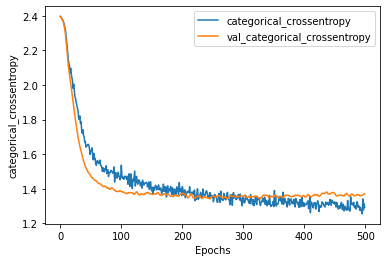

In [18]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
# Plot the history
plot_history(history, 'categorical_crossentropy')

In [19]:
print("Average accuracy of predicting exact LT4 dose: ", np.mean(accuracy_exact))
print("Average accuracy of predicting exact LT4 dose on patients with normal TSH: ", np.mean(accuracy_exact_normal))

Average accuracy of predicting exact LT4 dose:  0.4340314136125655
Average accuracy of predicting exact LT4 dose on patients with normal TSH:  0.47058823529411764


In [20]:
# CROSS-VALIDATION

#deleting previous run
if 'val_folds' in locals() or 'val_folds' in globals():
    del(val_folds)
    
accuracy_exact = []
accuracy_exact_normal = []

from sklearn.model_selection import cross_val_score,KFold
kf = KFold(n_splits=5, shuffle = True)

for train_index, test_index in kf.split(train):

    train_cv = train.iloc[train_index]
    test_cv = train.iloc[test_index]
    
    x_train, y_train = train_cv.drop(LT_doses, axis=1), train_cv[LT_doses]
    x_test, y_test = test_cv.drop(LT_doses, axis=1), test_cv[LT_doses]
        
    x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)
    
    # build the model
    model = build_model_using_sequential()
    
    # loss function
    ccle = CategoricalCrossentropy()
    
    
    model.compile(
        loss=ccle, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[ccle]
    )
    
    # train the model
    history = model.fit(
        x_train_scaled, 
        y_train, 
        epochs=500,
        batch_size=128,
        validation_split=0
    )
    
    # evaluating on test data and calculating accuracy
    
    class_labels = np.argmax(model.predict(x_test_scaled), axis=1)
    x_test['prediction'] = np.array(LT_doses)[class_labels.astype(int)]
    x_test['LT4'] = np.array(LT_doses)[np.where(y_test==1)[1].astype('int')]
    
    print("Run " + str(i+1) + " exact LT4 dose: ", sum(x_test['LT4'] == x_test['prediction'])/x_test.shape[0])
    accuracy_exact.append(sum(x_test['LT4'] == x_test['prediction'])/x_test.shape[0])
    
    x_test['TSH'] = np.exp(x_test['logTSH'])
    x_test_normal = x_test[x_test['TSH'] > 0.45]
    x_test_normal = x_test_normal[x_test_normal['TSH'] < 4.5]
    print("Run " + str(i+1) + " exact LT4 dose normal TSH: ", sum(x_test_normal['LT4'] == x_test_normal['prediction'])/x_test_normal.shape[0])
    accuracy_exact_normal.append(sum(x_test_normal['LT4'] == x_test_normal['prediction'])/x_test_normal.shape[0])

    if 'val_folds' in locals() or 'val_folds' in globals():
        val_folds = pd.concat([val_folds, x_test], axis = 0)
    else:
        val_folds = x_test

Epoch 1/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3961 - categorical_crossentropy: 2.3959
Epoch 2/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3920 - categorical_crossentropy: 2.3919
Epoch 3/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3860 - categorical_crossentropy: 2.3858
Epoch 4/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3817 - categorical_crossentropy: 2.3816
Epoch 5/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3746 - categorical_crossentropy: 2.3745
Epoch 6/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3633 - categorical_crossentropy: 2.3632
Epoch 7/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3516 - categorical_crossentropy: 2.3515
Epoch 8/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3361 - categorical_crossentropy: 2.3353
Epoch 9/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3118 - categorical_cros

5/5 [==============================] - 0s 2ms/step - loss: 1.5526 - categorical_crossentropy: 1.5524
Epoch 73/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5355 - categorical_crossentropy: 1.5354
Epoch 74/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5095 - categorical_crossentropy: 1.5117
Epoch 75/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5591 - categorical_crossentropy: 1.5584
Epoch 76/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5292 - categorical_crossentropy: 1.5309
Epoch 77/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5358 - categorical_crossentropy: 1.5356
Epoch 78/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5390 - categorical_crossentropy: 1.5420
Epoch 79/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5388 - categorical_crossentropy: 1.5429
Epoch 80/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5089 - categorical_crossent

5/5 [==============================] - 0s 2ms/step - loss: 1.4425 - categorical_crossentropy: 1.4453
Epoch 144/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4030 - categorical_crossentropy: 1.4026
Epoch 145/500
5/5 [==============================] - 0s 1ms/step - loss: 1.3843 - categorical_crossentropy: 1.3824
Epoch 146/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3950 - categorical_crossentropy: 1.3967
Epoch 147/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4597 - categorical_crossentropy: 1.4594
Epoch 148/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4090 - categorical_crossentropy: 1.4120
Epoch 149/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4423 - categorical_crossentropy: 1.4371
Epoch 150/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3851 - categorical_crossentropy: 1.3830
Epoch 151/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4438 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3811 - categorical_crossentropy: 1.3857
Epoch 215/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3670 - categorical_crossentropy: 1.3679
Epoch 216/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3397 - categorical_crossentropy: 1.3398
Epoch 217/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3408 - categorical_crossentropy: 1.3442
Epoch 218/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3472 - categorical_crossentropy: 1.3482
Epoch 219/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3954 - categorical_crossentropy: 1.3938
Epoch 220/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3722 - categorical_crossentropy: 1.3727
Epoch 221/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3547 - categorical_crossentropy: 1.3583
Epoch 222/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4011 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3373 - categorical_crossentropy: 1.3383
Epoch 286/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3191 - categorical_crossentropy: 1.3162
Epoch 287/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3372 - categorical_crossentropy: 1.3329
Epoch 288/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3032 - categorical_crossentropy: 1.3013
Epoch 289/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3297 - categorical_crossentropy: 1.3291
Epoch 290/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3202 - categorical_crossentropy: 1.3226
Epoch 291/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3370 - categorical_crossentropy: 1.3370
Epoch 292/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3664 - categorical_crossentropy: 1.3677
Epoch 293/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3403 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3049 - categorical_crossentropy: 1.3058
Epoch 357/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3157 - categorical_crossentropy: 1.3168
Epoch 358/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2947 - categorical_crossentropy: 1.2971
Epoch 359/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3747 - categorical_crossentropy: 1.3763
Epoch 360/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3282 - categorical_crossentropy: 1.3285
Epoch 361/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3108 - categorical_crossentropy: 1.3070
Epoch 362/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2975 - categorical_crossentropy: 1.3011
Epoch 363/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3190 - categorical_crossentropy: 1.3194
Epoch 364/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3015 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.2947 - categorical_crossentropy: 1.2940
Epoch 428/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2833 - categorical_crossentropy: 1.2827
Epoch 429/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3209 - categorical_crossentropy: 1.3217
Epoch 430/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2888 - categorical_crossentropy: 1.2884
Epoch 431/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2823 - categorical_crossentropy: 1.2820
Epoch 432/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3129 - categorical_crossentropy: 1.3082
Epoch 433/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2906 - categorical_crossentropy: 1.2873
Epoch 434/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3089 - categorical_crossentropy: 1.3126
Epoch 435/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2868 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.2786 - categorical_crossentropy: 1.2778
Epoch 499/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2937 - categorical_crossentropy: 1.2942
Epoch 500/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2488 - categorical_crossentropy: 1.2475
Run 10 exact LT4 dose:  0.42207792207792205
Run 10 exact LT4 dose normal TSH:  0.4393939393939394
Epoch 1/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3973 - categorical_crossentropy: 2.3973
Epoch 2/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3920 - categorical_crossentropy: 2.3918
Epoch 3/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3870 - categorical_crossentropy: 2.3868
Epoch 4/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3796 - categorical_crossentropy: 2.3795
Epoch 5/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3708 - categorical_crossentropy: 2.3706
Epoch 

5/5 [==============================] - 0s 2ms/step - loss: 1.5786 - categorical_crossentropy: 1.5829
Epoch 70/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5749 - categorical_crossentropy: 1.5694
Epoch 71/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5493 - categorical_crossentropy: 1.5499
Epoch 72/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5308 - categorical_crossentropy: 1.5331
Epoch 73/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5642 - categorical_crossentropy: 1.5652
Epoch 74/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5441 - categorical_crossentropy: 1.5404
Epoch 75/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5238 - categorical_crossentropy: 1.5281
Epoch 76/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5677 - categorical_crossentropy: 1.5675
Epoch 77/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5590 - categorical_crossent

5/5 [==============================] - 0s 2ms/step - loss: 1.4189 - categorical_crossentropy: 1.4159
Epoch 141/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3879 - categorical_crossentropy: 1.3913
Epoch 142/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4308 - categorical_crossentropy: 1.4296
Epoch 143/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3978 - categorical_crossentropy: 1.3979
Epoch 144/500
5/5 [==============================] - 0s 1ms/step - loss: 1.4007 - categorical_crossentropy: 1.4005
Epoch 145/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4616 - categorical_crossentropy: 1.4585
Epoch 146/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4179 - categorical_crossentropy: 1.4141
Epoch 147/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4473 - categorical_crossentropy: 1.4475
Epoch 148/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4150 - categorical_

5/5 [==============================] - 0s 1ms/step - loss: 1.3745 - categorical_crossentropy: 1.3762
Epoch 212/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3804 - categorical_crossentropy: 1.3794
Epoch 213/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3792 - categorical_crossentropy: 1.3792
Epoch 214/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3721 - categorical_crossentropy: 1.3788
Epoch 215/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3943 - categorical_crossentropy: 1.3938
Epoch 216/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3734 - categorical_crossentropy: 1.3685
Epoch 217/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3764 - categorical_crossentropy: 1.3703
Epoch 218/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3553 - categorical_crossentropy: 1.3539
Epoch 219/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3807 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3348 - categorical_crossentropy: 1.3335
Epoch 283/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3632 - categorical_crossentropy: 1.3702
Epoch 284/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3977 - categorical_crossentropy: 1.3981
Epoch 285/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3636 - categorical_crossentropy: 1.3641
Epoch 286/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3504 - categorical_crossentropy: 1.3475
Epoch 287/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3502 - categorical_crossentropy: 1.3485
Epoch 288/500
5/5 [==============================] - 0s 1ms/step - loss: 1.3647 - categorical_crossentropy: 1.3624
Epoch 289/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3762 - categorical_crossentropy: 1.3784
Epoch 290/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4023 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3178 - categorical_crossentropy: 1.3141
Epoch 354/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3322 - categorical_crossentropy: 1.3349
Epoch 355/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3374 - categorical_crossentropy: 1.3373
Epoch 356/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3365 - categorical_crossentropy: 1.3314
Epoch 357/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3262 - categorical_crossentropy: 1.3252
Epoch 358/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3337 - categorical_crossentropy: 1.3347
Epoch 359/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3439 - categorical_crossentropy: 1.3434
Epoch 360/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3423 - categorical_crossentropy: 1.3396
Epoch 361/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3448 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3274 - categorical_crossentropy: 1.3306
Epoch 425/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3132 - categorical_crossentropy: 1.3133
Epoch 426/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2930 - categorical_crossentropy: 1.2949
Epoch 427/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2989 - categorical_crossentropy: 1.2940
Epoch 428/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3256 - categorical_crossentropy: 1.3242
Epoch 429/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3552 - categorical_crossentropy: 1.3537
Epoch 430/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3192 - categorical_crossentropy: 1.3148
Epoch 431/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3053 - categorical_crossentropy: 1.3062
Epoch 432/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3155 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.2994 - categorical_crossentropy: 1.3030
Epoch 496/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3026 - categorical_crossentropy: 1.3039
Epoch 497/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3280 - categorical_crossentropy: 1.3304
Epoch 498/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3101 - categorical_crossentropy: 1.3112
Epoch 499/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3353 - categorical_crossentropy: 1.3318
Epoch 500/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3041 - categorical_crossentropy: 1.3087
Run 10 exact LT4 dose:  0.461038961038961
Run 10 exact LT4 dose normal TSH:  0.36923076923076925
Epoch 1/500
5/5 [==============================] - 0s 3ms/step - loss: 2.3948 - categorical_crossentropy: 2.3947
Epoch 2/500
5/5 [==============================] - 0s 2ms/step - loss: 2.3916 - categorical_crossentropy: 2.3915
E

5/5 [==============================] - 0s 2ms/step - loss: 1.5191 - categorical_crossentropy: 1.5183
Epoch 67/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5565 - categorical_crossentropy: 1.5568
Epoch 68/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5321 - categorical_crossentropy: 1.5312
Epoch 69/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5728 - categorical_crossentropy: 1.5731
Epoch 70/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5218 - categorical_crossentropy: 1.5194
Epoch 71/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5702 - categorical_crossentropy: 1.5704
Epoch 72/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5311 - categorical_crossentropy: 1.5292
Epoch 73/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5418 - categorical_crossentropy: 1.5377
Epoch 74/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5032 - categorical_crossent

5/5 [==============================] - 0s 2ms/step - loss: 1.4232 - categorical_crossentropy: 1.4214
Epoch 138/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4334 - categorical_crossentropy: 1.4287
Epoch 139/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3824 - categorical_crossentropy: 1.3819
Epoch 140/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4111 - categorical_crossentropy: 1.4106
Epoch 141/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4279 - categorical_crossentropy: 1.4284
Epoch 142/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4152 - categorical_crossentropy: 1.4170
Epoch 143/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4388 - categorical_crossentropy: 1.4401
Epoch 144/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4135 - categorical_crossentropy: 1.4100
Epoch 145/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4149 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3570 - categorical_crossentropy: 1.3538
Epoch 209/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3901 - categorical_crossentropy: 1.3885
Epoch 210/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3492 - categorical_crossentropy: 1.3501
Epoch 211/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3359 - categorical_crossentropy: 1.3361
Epoch 212/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3713 - categorical_crossentropy: 1.3713
Epoch 213/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3639 - categorical_crossentropy: 1.3660
Epoch 214/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3918 - categorical_crossentropy: 1.3937
Epoch 215/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3606 - categorical_crossentropy: 1.3560
Epoch 216/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3267 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3474 - categorical_crossentropy: 1.3465
Epoch 280/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3288 - categorical_crossentropy: 1.3303
Epoch 281/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3605 - categorical_crossentropy: 1.3545
Epoch 282/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3448 - categorical_crossentropy: 1.3408
Epoch 283/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3715 - categorical_crossentropy: 1.3687
Epoch 284/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3168 - categorical_crossentropy: 1.3194
Epoch 285/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3126 - categorical_crossentropy: 1.3161
Epoch 286/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3552 - categorical_crossentropy: 1.3578
Epoch 287/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3377 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3404 - categorical_crossentropy: 1.3389
Epoch 351/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3053 - categorical_crossentropy: 1.3112
Epoch 352/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3006 - categorical_crossentropy: 1.2996
Epoch 353/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3075 - categorical_crossentropy: 1.3097
Epoch 354/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2912 - categorical_crossentropy: 1.2881
Epoch 355/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3046 - categorical_crossentropy: 1.3059
Epoch 356/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3257 - categorical_crossentropy: 1.3348
Epoch 357/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3227 - categorical_crossentropy: 1.3182
Epoch 358/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2910 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.2855 - categorical_crossentropy: 1.2800
Epoch 422/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2950 - categorical_crossentropy: 1.2922
Epoch 423/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2994 - categorical_crossentropy: 1.2969
Epoch 424/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2929 - categorical_crossentropy: 1.2924
Epoch 425/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3200 - categorical_crossentropy: 1.3206
Epoch 426/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2926 - categorical_crossentropy: 1.2919
Epoch 427/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2826 - categorical_crossentropy: 1.2855
Epoch 428/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3106 - categorical_crossentropy: 1.3075
Epoch 429/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2885 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.2873 - categorical_crossentropy: 1.2840
Epoch 493/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2624 - categorical_crossentropy: 1.2591
Epoch 494/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3018 - categorical_crossentropy: 1.3050
Epoch 495/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2851 - categorical_crossentropy: 1.2856
Epoch 496/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2638 - categorical_crossentropy: 1.2636
Epoch 497/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3265 - categorical_crossentropy: 1.3303
Epoch 498/500
5/5 [==============================] - 0s 1ms/step - loss: 1.2605 - categorical_crossentropy: 1.2602
Epoch 499/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2872 - categorical_crossentropy: 1.2842
Epoch 500/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2689 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.6241 - categorical_crossentropy: 1.6198
Epoch 64/500
5/5 [==============================] - 0s 2ms/step - loss: 1.6351 - categorical_crossentropy: 1.6360
Epoch 65/500
5/5 [==============================] - 0s 2ms/step - loss: 1.6021 - categorical_crossentropy: 1.6031
Epoch 66/500
5/5 [==============================] - 0s 2ms/step - loss: 1.6010 - categorical_crossentropy: 1.5982
Epoch 67/500
5/5 [==============================] - 0s 2ms/step - loss: 1.6091 - categorical_crossentropy: 1.6092
Epoch 68/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5874 - categorical_crossentropy: 1.5878
Epoch 69/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5845 - categorical_crossentropy: 1.5861
Epoch 70/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5898 - categorical_crossentropy: 1.5852
Epoch 71/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5700 - categorical_crossent

5/5 [==============================] - 0s 2ms/step - loss: 1.4382 - categorical_crossentropy: 1.4331
Epoch 135/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4526 - categorical_crossentropy: 1.4545
Epoch 136/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3912 - categorical_crossentropy: 1.3942
Epoch 137/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4245 - categorical_crossentropy: 1.4222
Epoch 138/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4368 - categorical_crossentropy: 1.4340
Epoch 139/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4010 - categorical_crossentropy: 1.3984
Epoch 140/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4045 - categorical_crossentropy: 1.4017
Epoch 141/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4341 - categorical_crossentropy: 1.4306
Epoch 142/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4131 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3772 - categorical_crossentropy: 1.3768
Epoch 206/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3877 - categorical_crossentropy: 1.3888
Epoch 207/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3602 - categorical_crossentropy: 1.3579
Epoch 208/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3711 - categorical_crossentropy: 1.3727
Epoch 209/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3660 - categorical_crossentropy: 1.3671
Epoch 210/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3613 - categorical_crossentropy: 1.3606
Epoch 211/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3820 - categorical_crossentropy: 1.3838
Epoch 212/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3462 - categorical_crossentropy: 1.3488
Epoch 213/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3988 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3213 - categorical_crossentropy: 1.3178
Epoch 277/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3315 - categorical_crossentropy: 1.3310
Epoch 278/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3496 - categorical_crossentropy: 1.3500
Epoch 279/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3613 - categorical_crossentropy: 1.3604
Epoch 280/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3310 - categorical_crossentropy: 1.3276
Epoch 281/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3524 - categorical_crossentropy: 1.3488
Epoch 282/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3451 - categorical_crossentropy: 1.3497
Epoch 283/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3438 - categorical_crossentropy: 1.3449
Epoch 284/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3483 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3319 - categorical_crossentropy: 1.3330
Epoch 348/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3401 - categorical_crossentropy: 1.3406
Epoch 349/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3104 - categorical_crossentropy: 1.3080
Epoch 350/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3353 - categorical_crossentropy: 1.3387
Epoch 351/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3274 - categorical_crossentropy: 1.3273
Epoch 352/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2992 - categorical_crossentropy: 1.2977
Epoch 353/500
5/5 [==============================] - 0s 1ms/step - loss: 1.3045 - categorical_crossentropy: 1.3030
Epoch 354/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2917 - categorical_crossentropy: 1.2902
Epoch 355/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3182 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3068 - categorical_crossentropy: 1.3016
Epoch 419/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2983 - categorical_crossentropy: 1.3010
Epoch 420/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3079 - categorical_crossentropy: 1.3067
Epoch 421/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3171 - categorical_crossentropy: 1.3185
Epoch 422/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3124 - categorical_crossentropy: 1.3111
Epoch 423/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2901 - categorical_crossentropy: 1.2885
Epoch 424/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2646 - categorical_crossentropy: 1.2618
Epoch 425/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3234 - categorical_crossentropy: 1.3236
Epoch 426/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3016 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.2665 - categorical_crossentropy: 1.2671
Epoch 490/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2737 - categorical_crossentropy: 1.2742
Epoch 491/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2719 - categorical_crossentropy: 1.2711
Epoch 492/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2772 - categorical_crossentropy: 1.2789
Epoch 493/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2431 - categorical_crossentropy: 1.2428
Epoch 494/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2754 - categorical_crossentropy: 1.2734
Epoch 495/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2757 - categorical_crossentropy: 1.2711
Epoch 496/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2831 - categorical_crossentropy: 1.2902
Epoch 497/500
5/5 [==============================] - 0s 2ms/step - loss: 1.2739 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.5882 - categorical_crossentropy: 1.5849
Epoch 61/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5820 - categorical_crossentropy: 1.5809
Epoch 62/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5578 - categorical_crossentropy: 1.5627
Epoch 63/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5770 - categorical_crossentropy: 1.5777
Epoch 64/500
5/5 [==============================] - 0s 2ms/step - loss: 1.6021 - categorical_crossentropy: 1.6061
Epoch 65/500
5/5 [==============================] - 0s 1ms/step - loss: 1.5642 - categorical_crossentropy: 1.5629
Epoch 66/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5782 - categorical_crossentropy: 1.5820
Epoch 67/500
5/5 [==============================] - 0s 1ms/step - loss: 1.5823 - categorical_crossentropy: 1.5849
Epoch 68/500
5/5 [==============================] - 0s 2ms/step - loss: 1.5578 - categorical_crossent

5/5 [==============================] - 0s 2ms/step - loss: 1.4659 - categorical_crossentropy: 1.4656
Epoch 132/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4335 - categorical_crossentropy: 1.4326
Epoch 133/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4381 - categorical_crossentropy: 1.4364
Epoch 134/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4616 - categorical_crossentropy: 1.4614
Epoch 135/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4489 - categorical_crossentropy: 1.4484
Epoch 136/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4320 - categorical_crossentropy: 1.4294
Epoch 137/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4580 - categorical_crossentropy: 1.4587
Epoch 138/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4368 - categorical_crossentropy: 1.4374
Epoch 139/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4379 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.4135 - categorical_crossentropy: 1.4122
Epoch 203/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3978 - categorical_crossentropy: 1.3972
Epoch 204/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4163 - categorical_crossentropy: 1.4202
Epoch 205/500
5/5 [==============================] - 0s 1ms/step - loss: 1.3623 - categorical_crossentropy: 1.3664
Epoch 206/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4090 - categorical_crossentropy: 1.4073
Epoch 207/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4210 - categorical_crossentropy: 1.4233
Epoch 208/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3599 - categorical_crossentropy: 1.3641
Epoch 209/500
5/5 [==============================] - 0s 2ms/step - loss: 1.4028 - categorical_crossentropy: 1.4024
Epoch 210/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3717 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3767 - categorical_crossentropy: 1.3842
Epoch 274/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3952 - categorical_crossentropy: 1.3915
Epoch 275/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3441 - categorical_crossentropy: 1.3435
Epoch 276/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3814 - categorical_crossentropy: 1.3792
Epoch 277/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3594 - categorical_crossentropy: 1.3595
Epoch 278/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3506 - categorical_crossentropy: 1.3497
Epoch 279/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3801 - categorical_crossentropy: 1.3822
Epoch 280/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3896 - categorical_crossentropy: 1.3904
Epoch 281/500
5/5 [==============================] - 0s 1ms/step - loss: 1.3876 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3569 - categorical_crossentropy: 1.3554
Epoch 345/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3439 - categorical_crossentropy: 1.3403
Epoch 346/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3629 - categorical_crossentropy: 1.3621
Epoch 347/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3745 - categorical_crossentropy: 1.3793
Epoch 348/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3367 - categorical_crossentropy: 1.3343
Epoch 349/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3239 - categorical_crossentropy: 1.3289
Epoch 350/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3314 - categorical_crossentropy: 1.3332
Epoch 351/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3275 - categorical_crossentropy: 1.3301
Epoch 352/500
5/5 [==============================] - 0s 1ms/step - loss: 1.3368 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3342 - categorical_crossentropy: 1.3319
Epoch 416/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3163 - categorical_crossentropy: 1.3150
Epoch 417/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3495 - categorical_crossentropy: 1.3486
Epoch 418/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3444 - categorical_crossentropy: 1.3453
Epoch 419/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3348 - categorical_crossentropy: 1.3353
Epoch 420/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3589 - categorical_crossentropy: 1.3532
Epoch 421/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3571 - categorical_crossentropy: 1.3597
Epoch 422/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3272 - categorical_crossentropy: 1.3244
Epoch 423/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3389 - categorical_

5/5 [==============================] - 0s 2ms/step - loss: 1.3297 - categorical_crossentropy: 1.3275
Epoch 487/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3303 - categorical_crossentropy: 1.3340
Epoch 488/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3088 - categorical_crossentropy: 1.3090
Epoch 489/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3303 - categorical_crossentropy: 1.3293
Epoch 490/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3543 - categorical_crossentropy: 1.3540
Epoch 491/500
5/5 [==============================] - 0s 1ms/step - loss: 1.3258 - categorical_crossentropy: 1.3301
Epoch 492/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3128 - categorical_crossentropy: 1.3161
Epoch 493/500
5/5 [==============================] - 0s 1ms/step - loss: 1.3230 - categorical_crossentropy: 1.3200
Epoch 494/500
5/5 [==============================] - 0s 2ms/step - loss: 1.3166 - categorical_

In [21]:
print("Average accuracy of predicting exact LT4 dose: ", 
      sum(val_folds['LT4'] == val_folds['prediction'])/val_folds.shape[0])

val_folds_normal = val_folds[val_folds['TSH'] > 0.45]
val_folds_normal = val_folds_normal[val_folds_normal['TSH'] < 4.5]

print("Average accuracy of predicting exact LT4 dose on normal TSH: ", 
      sum(val_folds_normal['LT4'] == val_folds_normal['prediction'])/val_folds_normal.shape[0])



Average accuracy of predicting exact LT4 dose:  0.4445893089960887
Average accuracy of predicting exact LT4 dose on normal TSH:  0.43109540636042404
